In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 

from collections import defaultdict
from itertools import product
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from utils_hiv.DRM_utils import *

In [2]:
import os 
os.chdir('/Users/lucblassel')

In [3]:
dirname = "coefficient_rankings_multi_target"
os.makedirs(dirname, exist_ok=True)

In [4]:
models = ['RF', 'Bayes', 'Logistic', '1_minus_exact_p_value']
targets = ['encoded_label', 'hasDRM']

In [5]:
x_order = ['228_R', '228_H', '203_K', '135_L', '208_Y', '218_E']
x_labels = ['L228R', 'L228H', 'E203K', 'I135L', 'H208Y', 'D218E']
treatment_order = ['NRTI', 'NNRTI', 'Other']
all_order = ['ALL', 'DRMs', 'SDRMs'] + treatment_order
corresp = {k:v for k,v in zip(x_order, x_labels)}

In [6]:
DRM_names = get_DRM_names()

In [7]:
coeffs_multi = pd.read_csv('whole_dataset_multi_targets/coefs_df.tsv', sep='\t', index_col=0)
fisher_p_values = pd.read_csv('/Users/lucblassel/Documents/Work/utils_hiv/utils_hiv/data/fisher_p_values.tsv', sep='\t', index_col=0)

In [8]:
pivoted_p_values = pd.pivot_table(fisher_p_values[
    (fisher_p_values['DRMs'] == 'ALL') & 
    (fisher_p_values['seqs'] == 'None') & 
    (fisher_p_values['target'].isin(['encoded_label', 'hasDRM']))
].reset_index(), columns='index', index=['subtype', 'target'], values='p_value', aggfunc=lambda x: 1-x).reset_index()
for k,v in {'dir':'noDir','normalized':False, 'model':models[-1]}.items():
    pivoted_p_values[k] = v

In [9]:
concated_coeffs = pd.concat([coeffs_multi, pivoted_p_values], axis=0, sort=False)

In [10]:
concated_coeffs.to_csv(os.path.join(dirname, 'concated_coeffs.tsv'), sep='\t', index=True, header=True)

In [11]:
def get_rank(row):
    subtype, model = row.loc[['subtype', 'model']]
    col_name = f'{subtype}_{model}'
    return (row.filter(regex=r'\d+_\S')
                .sort_values(ascending=False)
                .reset_index()
                .rename({'index':'feature'}, axis=1)
                .reset_index()
                .rename({'index':col_name}, axis=1)
                .set_index('feature')
                [col_name])

In [12]:
subset_treatment_status = concated_coeffs[
    (concated_coeffs['dir'] != 'results_whole_training_set') & 
    (concated_coeffs['target'] == 'encoded_label') & 
    (concated_coeffs['model'].isin(models))
]

subset_hasDRM = concated_coeffs[
    (concated_coeffs['dir'] != 'results_whole_training_set') & 
    (concated_coeffs['target'] == 'hasDRM') & 
    (concated_coeffs['model'].isin(models))
]

In [13]:
to_concat = []
for _, row in subset_treatment_status.iterrows():
    to_concat.append(get_rank(row))
ranks_treatment_status = pd.concat(to_concat, axis=1)
ranks_treatment_status['average'] = ranks_treatment_status.mean(axis=1)
ranks_treatment_status['average_subtypes'] = ranks_treatment_status.filter(regex=r'(B|C)_.*', axis=1).mean(axis=1)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [14]:
to_concat = []
for _, row in subset_hasDRM.iterrows():
    to_concat.append(get_rank(row))
ranks_hasDRM = pd.concat(to_concat, axis=1)
ranks_hasDRM['average'] = ranks_hasDRM.mean(axis=1)
ranks_hasDRM['average_subtypes'] = ranks_hasDRM.filter(regex=r'(B|C)_.*', axis=1).mean(axis=1)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [15]:
ranks_treatment_status.to_csv(os.path.join(dirname, 'ranks_treatment_status.tsv'), sep='\t')
ranks_hasDRM.to_csv(os.path.join(dirname, 'ranks_hasDRM.tsv'), sep='\t')

sorted by average rank in models trained on treatment status task

In [16]:
ranks_treatment_status.sort_values(by='average_subtypes').iloc[:10]

,ALL_Bayes,B_Bayes,C_Bayes,ALL_Logistic,B_Logistic,C_Logistic,ALL_RF,B_RF,C_RF,ALL_1_minus_exact_p_value,B_1_minus_exact_p_value,C_1_minus_exact_p_value,average,average_subtypes
228_R,47,40,51,26,54,119,26,19,38,6,5,1,36.000000,40.875
203_K,45,44,46,85,111,132,35,32,39,1,6,0,48.000000,51.250
218_E,62,50,73,72,73,156,46,29,85,2,0,7,54.583333,59.125
228_H,48,39,57,132,124,184,42,30,68,3,2,5,61.166667,63.625
135_L,46,38,52,239,260,148,73,58,54,11,15,2,83.000000,78.375
165_L,96,88,99,130,149,112,109,94,91,13,13,6,83.333333,81.500
178_L,11,9,8,316,307,261,19,6,28,17,56,3,86.750000,84.750
139_K,88,96,64,168,207,151,99,98,64,14,24,4,89.750000,88.500
208_Y,56,42,100,145,133,266,63,37,143,5,1,15,83.833333,92.125
203_D,33,24,43,281,238,293,54,49,45,12,9,47,94.000000,93.500


sorted by average rank in models trained on has DRM or not task

In [17]:
ranks_hasDRM.sort_values(by='average_subtypes').iloc[:10]

,ALL_Bayes,B_Bayes,C_Bayes,ALL_Logistic,B_Logistic,C_Logistic,ALL_RF,B_RF,C_RF,ALL_1_minus_exact_p_value,B_1_minus_exact_p_value,C_1_minus_exact_p_value,average,average_subtypes
228_R,53,56,57,9,5,0,33,32,35,17,0,11,25.666667,24.500
203_K,52,59,47,83,58,7,41,51,32,26,2,7,38.750000,32.875
214_L,1,3,2,265,296,24,0,3,0,29,6,9,53.166667,42.875
218_E,79,74,76,73,22,30,56,58,67,0,11,22,47.333333,45.000
228_H,50,49,62,179,79,110,45,35,62,5,5,28,59.083333,53.750
223_Q,67,47,135,2,2,12,78,61,189,21,3,40,54.750000,61.125
135_L,45,38,56,272,300,10,52,60,42,12,29,13,77.416667,68.500
122_P,19,14,66,196,182,162,2,1,69,3,7,68,65.750000,71.125
139_R,68,52,119,137,125,40,83,72,109,2,20,46,72.750000,72.875
208_Y,70,57,98,144,141,76,67,56,116,27,10,37,74.916667,73.875


In [18]:
common_features = set(ranks_treatment_status.sort_values(by='average_subtypes').iloc[:10].index) & set(ranks_hasDRM.sort_values(by='average_subtypes').iloc[:10].index)

In [19]:
pd.concat([ranks_treatment_status.sort_values(by='average_subtypes').iloc[:10].reset_index().reset_index(drop=False).set_index('index')['level_0'].rename('rank_treatment'),
ranks_hasDRM.sort_values(by='average_subtypes').iloc[:10].reset_index().reset_index(drop=False).set_index('index')['level_0'].rename('rank_DRM')], axis=1).loc[common_features].sort_values(by=['rank_treatment', 'rank_DRM']).astype(int)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,rank_treatment,rank_DRM
228_R,0,0
203_K,1,1
218_E,2,3
228_H,3,4
135_L,4,6
208_Y,8,9


## Ratios

In [20]:
from utils_hiv.DRM_utils import *

In [21]:
drms = {
    'ALL': set(get_all_DRMs()), 
    'DRMs': set(get_DRMs_only()),
    'SDRMs': set(get_SDRMs()),
    'NRTI': set(get_NRTI()),
    'NNRTI': set(get_NNRTI()),
    'Other': set(get_Other())
}

In [22]:
uk_data = pd.read_csv('Documents/Work/hiv-drm-detection/data_pre_split/UK-data-with-scores.tsv.homo', sep='\t', index_col=0)

In [23]:
africa_data = pd.read_csv('Documents/Work/hiv-drm-detection/data_pre_split/Africa-data-with-scores.tsv.homo', sep='\t', index_col=0)

In [24]:
def get_ratios(data, mut, prevalence=False):
    freqs = (
        data.filter(list(common_features) + [mut], axis=1)
        .groupby(mut)
        .apply(lambda x: x.apply(
            lambda y: y.value_counts(normalize=True).get(1,0)
            )
        ).filter(common_features)
        .reindex([0,1])
        .fillna(0)
    )
    if prevalence: 
        return freqs.loc[1].rename(mut)
        
    return (freqs.loc[1] / freqs.loc[0]).rename(mut)

In [25]:
def get_contingency(v1, v2):
    return np.bincount(2 * v1 + v2, minlength=4).reshape(2,2)
def compute_ratio(contingency):
    return (contingency[1,1] / contingency[:,1].sum()) / (contingency[1,0] / contingency[:,0].sum())
def compute_prevalence(contingency):
    return contingency[1,1] / contingency[:,1].sum()
def compute_cooccurrence_prop(contingency):
    return contingency[1,1] / contingency[1,:].sum()
def compute_weighted_cooccurrence_prop(contingency):
    return (contingency[1,1] / contingency[:, 1].sum()) / ( 
    (contingency[1,1] / contingency[:, 1].sum()) + 
    (contingency[1,0] / contingency[:, 0].sum())
)

In [26]:
def numpy_version(subset, mut, func):
    """subset columns must be ordered by common_features, and lastly the DRM"""
    results = dict()
    for i, new_mut in enumerate(common_features):
        contingency = get_contingency(subset[:,i], subset[:,-1])
        results[new_mut] = func(contingency)
    return results

In [27]:
def get_prevalence_proportion(data, mut):
    proportions = {}
    for new_mut in common_features:
        tab = pd.crosstab(data[new_mut], data[mut])
        proportions[new_mut] = tab.iloc[1,1] / tab.iloc[1].sum()
        
    return pd.Series(proportions, name=mut)

In [28]:
def get_inter_count(data, mut):
    counts = (
        data.filter(list(common_features) + [mut], axis=1)
        .groupby(mut)
        .apply(lambda x: x.apply(
            lambda y: y.value_counts().get(1,0)
            )
        ).filter(common_features)
        .reindex([0,1])
        .fillna(0)
    )

    return counts.loc[1].rename(mut)

In [29]:
for key, muts in drms.items():
    uk_data[key] = uk_data.filter(muts, axis=1).any(axis=1).astype(int)

In [30]:
for key, muts in drms.items():
    africa_data[key] = africa_data.filter(muts, axis=1).any(axis=1).astype(int)

In [31]:
drm_counts = pd.concat(
    [
        africa_data.filter(drms['ALL'], axis=1).sum().rename('Africa'),
        uk_data.filter(drms['ALL'], axis=1).sum().rename('UK')
    ], axis=1)

In [32]:
new_counts = pd.concat(
    [
        africa_data.filter(common_features, axis=1).sum().rename('Africa'),
        uk_data.filter(common_features, axis=1).sum().rename('UK')
    ], axis=1)

In [33]:
pos= uk_data[
    (uk_data['ALL'] == 1) & 
    (uk_data['hasDRM'] == 0)
].filter(drms['ALL'], axis=1)

pos[pos.any()[pos.any()].index].sum()

Series([], dtype: float64)

In [34]:
to_concat = []
cols = set(uk_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_ratios(uk_data, mut))
drm_ratios = pd.concat(to_concat, axis=1)
drm_ratios

,215_N,70_T,41_L,69_S,215_L,69_G,101_N,115_F,103_N,210_W,...,69_E,234_I,ALL,DRMs,SDRMs,NRTI,NNRTI,Other,encoded_label,hasDRM
228_H,0.000000,48.879401,22.174480,5.432748,8.370573,48.54458,0.000000,10.260000,7.306491,23.541484,...,0.000000,0.000000,9.160917,4.504864,19.381598,18.769091,7.742585,5.170006,6.421509,9.160917
203_K,0.000000,0.000000,22.210016,1.321351,3.107507,0.00000,0.000000,8.175299,6.825116,39.030273,...,43.556078,0.000000,20.057450,3.821694,47.993382,49.126432,7.313922,3.223514,10.994115,20.057450
135_L,12.878247,0.000000,2.846799,1.568332,0.000000,0.00000,0.000000,6.955932,3.962568,3.372922,...,20.606308,0.000000,2.353750,1.748419,3.238788,3.311359,2.311003,1.564736,1.796458,2.353750
208_Y,0.000000,0.000000,83.731761,0.822606,3.884384,0.00000,12.370098,2.011765,4.491940,102.832833,...,0.000000,0.000000,14.939342,8.607935,25.483212,35.327777,6.202160,6.494513,8.828482,14.939342
218_E,0.000000,27.708084,31.497841,4.092965,4.744996,0.00000,15.110778,7.461818,6.162334,22.921548,...,66.507784,0.000000,26.973812,4.635907,56.587720,61.419257,7.535879,4.051662,13.082997,26.973812
228_R,0.000000,0.000000,26.321452,1.491658,3.506258,0.00000,22.431111,24.930841,14.598806,31.748548,...,0.000000,30.714049,115.676157,5.929160,282.863650,73.616500,26.971166,3.446145,18.096979,115.676157


In [35]:
to_concat = []
cols = set(africa_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_ratios(africa_data, mut))
drm_ratios_africa = pd.concat(to_concat, axis=1)
drm_ratios_africa

,215_N,70_T,41_L,69_S,215_L,69_G,101_N,115_F,103_N,210_W,...,69_E,234_I,ALL,DRMs,SDRMs,NRTI,NNRTI,Other,encoded_label,hasDRM
228_H,0.0,0.000000,8.507492,0.0,0.0,52.117647,26.039216,9.572115,1.566879,12.388235,...,0.0,0.000000,34.139508,12.267370,32.483370,26.696215,28.174871,8.081246,23.058542,34.139508
203_K,0.0,0.000000,10.102647,0.0,0.0,0.000000,0.000000,0.000000,2.535870,13.945481,...,0.0,0.000000,17.404455,6.273087,19.879823,18.160691,17.243021,4.596209,14.111828,17.404455
135_L,0.0,29.992481,1.586579,0.0,0.0,0.000000,0.000000,0.000000,3.394904,0.577540,...,0.0,0.000000,2.398691,1.801502,3.171906,2.943944,2.665776,1.216357,2.560970,2.398691
208_Y,0.0,332.416667,236.082902,0.0,0.0,0.000000,0.000000,0.000000,4.588717,60.988235,...,0.0,0.000000,inf,30.110818,inf,inf,inf,8.485308,inf,inf
218_E,0.0,0.000000,6.212708,0.0,0.0,0.000000,27.666667,0.000000,3.569002,5.197861,...,0.0,0.000000,inf,18.401055,inf,inf,inf,4.166892,inf,inf
228_R,0.0,0.000000,5.365520,0.0,0.0,0.000000,6.845361,10.369792,4.933621,5.829758,...,0.0,13.833333,42.395467,4.516623,61.718404,33.415671,53.532254,3.216766,32.512545,42.395467


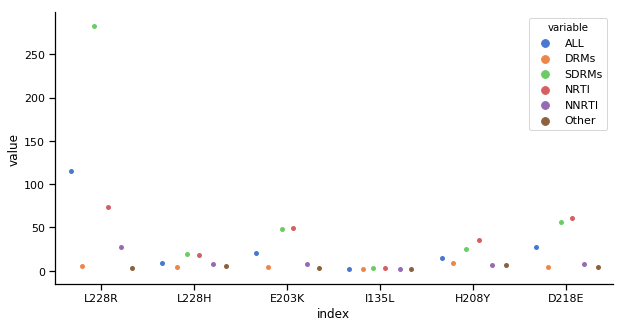

In [36]:
melted = pd.melt(drm_ratios.reset_index(), id_vars='index')
sns.set_context('notebook')
fig = plt.figure(figsize=(10,5))
sns.stripplot(data=melted[melted['variable'].isin(drms.keys())], x='index', hue='variable', y='value', palette='muted', dodge=True, order=x_order, hue_order=all_order)
fig.axes[0].set_xticklabels(x_labels)
sns.despine()

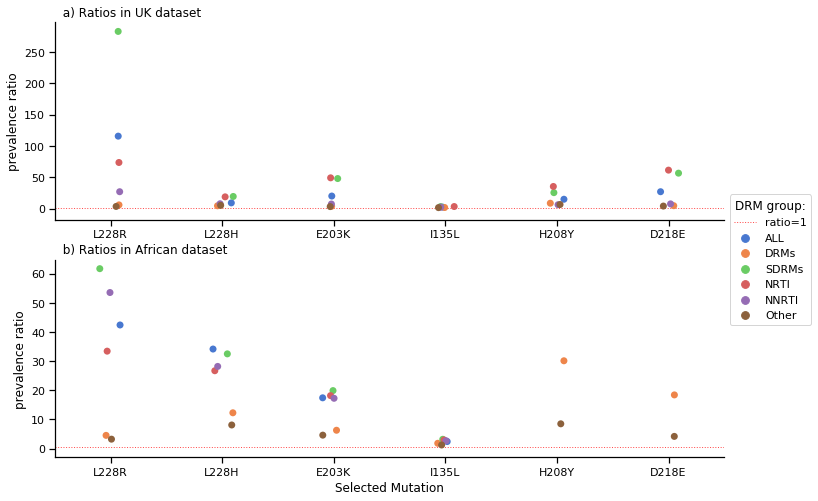

In [37]:
sns.set_context('notebook')
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((2, 1), (1, 0), colspan=2, rowspan=1)

melted_africa = pd.melt(drm_ratios_africa.reset_index(), id_vars='index')

sns.stripplot(
    data=melted[melted['variable'].isin(drms.keys())], ax=ax1,
    x='index', y='value', hue='variable', dodge=False, palette='muted', size=7, order=x_order, hue_order=all_order)

sns.stripplot(
    data=melted_africa[melted_africa['variable'].isin(drms.keys())], ax=ax2,
    x='index', y='value', hue='variable', dodge=False, palette='muted', size=7, order=x_order, hue_order=all_order)
sns.despine()
for ax in [ax1, ax2]:
    ax.axhline(y=0.5, color='red', zorder=0.5, ls=':', lw=1, alpha=0.7, label="ratio=1")
    ax.set_ylabel("prevalence ratio")
    ax.set_xticklabels(x_labels)
ax1.get_legend().remove()
ax1.set_xlabel("")
ax2.set_xlabel("Selected Mutation")
ax2.legend(loc='center left', bbox_to_anchor=(1, 1), title="DRM group:")

ax1.set_title("  a) Ratios in UK dataset", loc="left")
ax2.set_title("  b) Ratios in African dataset", loc="left")
plt.savefig(os.path.join(dirname, 'general_ratios.svg'), format='svg')

In [38]:
def get_valid_muts(counts, country, n_sequences):
    threshold = n_sequences * 1e-3 if country == 'UK' else 30
    return counts[country][
        counts[country] > threshold
    ].index.tolist()

In [39]:
def get_drm_type(mut):
    for key, muts in drms.items():
        if key not in ['NRTI', 'NNRTI', 'Other']:
            continue
        if mut in muts:
            return key
    return "New"

In [40]:
uk_valid_drms = get_valid_muts(drm_counts, 'UK', uk_data.shape[0])
africa_valid_drms = get_valid_muts(drm_counts, 'Africa', africa_data.shape[0])

In [41]:
uk_valid_new = get_valid_muts(new_counts, 'UK', uk_data.shape[0])
africa_valid_new = get_valid_muts(new_counts, 'Africa', africa_data.shape[0])

In [42]:
subset_ratio = drm_ratios.filter(uk_valid_drms, axis=1).filter(uk_valid_new, axis=0)
subset_melted = pd.melt(subset_ratio.reset_index(), id_vars='index')
subset_melted['group'] = subset_melted['variable'].apply(get_drm_type)

In [43]:
subset_ratio_africa = drm_ratios_africa.filter(africa_valid_drms, axis=1).filter(africa_valid_new, axis=0)
subset_melted_africa = pd.melt(subset_ratio_africa.reset_index(), id_vars='index')
subset_melted_africa['group'] = subset_melted_africa['variable'].apply(get_drm_type)

[Text(0, 0, 'L228R'),
 Text(0, 0, 'L228H'),
 Text(0, 0, 'E203K'),
 Text(0, 0, 'I135L'),
 Text(0, 0, 'H208Y'),
 Text(0, 0, 'D218E')]

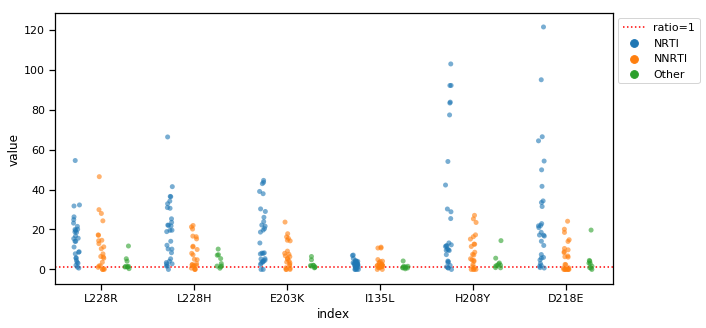

In [44]:
fig = plt.figure(figsize=(10,5))
sns.stripplot(data=subset_melted, x='index', y='value', hue='group', dodge=True, alpha=0.6, order=x_order, hue_order=treatment_order)
plt.axhline(y=1, zorder=0.5, color='red', ls=':', label='ratio=1')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
fig.axes[0].set_xticklabels(x_labels)
# plt.yscale('log', basey=2)
# plt.ylim((1.9**-3, 2.1**7))
# _ = plt.yticks([2**i for i in range(-3, 8)])

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/seaborn/categorical.py:1187: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


[Text(0, 0, 'L228R'),
 Text(0, 0, 'L228H'),
 Text(0, 0, 'E203K'),
 Text(0, 0, 'I135L'),
 Text(0, 0, 'H208Y'),
 Text(0, 0, 'D218E')]

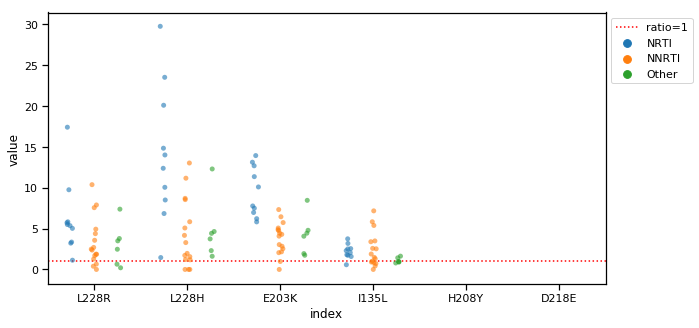

In [45]:
fig = plt.figure(figsize=(10,5))
sns.stripplot(data=subset_melted_africa, x='index', y='value', hue='group', dodge=True, alpha=0.6, order=x_order, hue_order=treatment_order)
plt.axhline(y=1, zorder=0.5, color='red', ls=':', label='ratio=1')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
fig.axes[0].set_xticklabels(x_labels)
# plt.yscale('log', basey=2)
# plt.ylim((1.9**-3, 2.1**7))
# _ = plt.yticks([2**i for i in range(-3, 8)])

# Detailed ratio figures in Africa

In [46]:
to_concat = []
cols = set(africa_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_ratios(africa_data, mut, True))
positive_prevalence_africa = pd.concat(to_concat, axis=1)

subset_prevalence_africa = positive_prevalence_africa.filter(africa_valid_drms, axis=1).filter(africa_valid_new, axis=0)
prevalence_melted_africa = pd.melt(subset_prevalence_africa.reset_index(), id_vars='index')
prevalence_melted_africa['group'] = prevalence_melted_africa['variable'].apply(get_drm_type)

In [47]:
to_concat = []
cols = set(africa_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_inter_count(africa_data, mut))
positive_counts_africa = pd.concat(to_concat, axis=1)

subset_counts_africa = positive_counts_africa.filter(africa_valid_drms, axis=1).filter(africa_valid_new, axis=0)
counts_melted_africa = pd.melt(subset_counts_africa.reset_index(), id_vars='index')
counts_melted_africa['group'] = counts_melted_africa['variable'].apply(get_drm_type)

In [48]:
shapes = [africa_data.shape[0], uk_data.shape[0]]
drm_prevs = drm_counts / shapes

In [49]:
indexer = ['index', 'variable', 'group']
all_melted_africa = pd.concat([
    subset_melted_africa.set_index(indexer),
    prevalence_melted_africa.set_index(indexer).rename({'value':'positive prevalence'}, axis=1),
    counts_melted_africa.set_index(indexer).rename({'value':'count'}, axis=1)
], axis=1).reset_index()
all_melted_africa['drm prevalence'] = all_melted_africa['variable'].apply(lambda x: drm_prevs['Africa'].loc[x])

# Detailed ratio figures for Africa

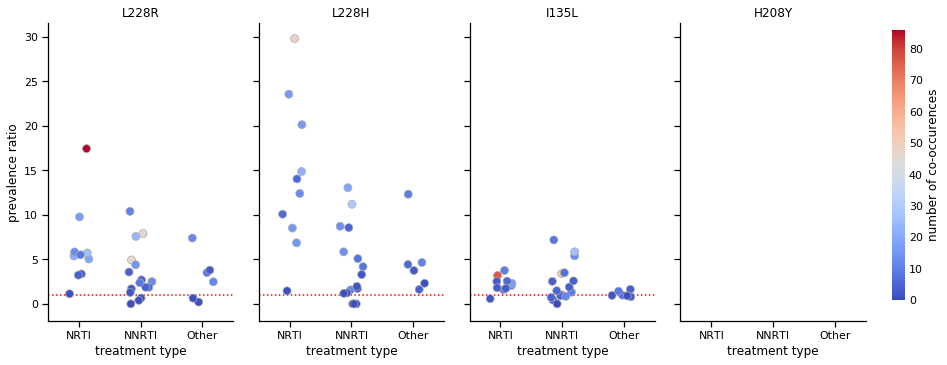

In [50]:
# color map Africa
norm = mpl.colors.Normalize(vmin=all_melted_africa['count'].min(), vmax=all_melted_africa['count'].max())
cmap = mpl.cm.coolwarm
colors = {round(k,6):v for k,v in zip(all_melted_africa['value'], cmap(norm(all_melted_africa['count'].values)))}

grid = (sns.FacetGrid(data=all_melted_africa, col='index', col_order=x_order[:2] + x_order[-3:-1], aspect=0.6, height=5)
    .map_dataframe(sns.stripplot, x='group', y='value', order=treatment_order, size=8, jitter=0.2, linewidth=0.7, edgecolor="#aaaaaa")
    .map(plt.axhline, y=1, ls=':', color='red', zorder=0.5)
    .set_titles(template="{col_name}")
    .set_axis_labels('treatment type', 'prevalence ratio')
    .add_legend()
)
# correct facet titles + change color based on prevalence
for ax in grid.axes.flatten():
    for collection in ax.collections:
        offsets = collection.get_offsets()
        collection.set_facecolors([colors.get(round(y,6)) for _, y in offsets])
    ax.set_title(corresp.get(ax.get_title()))

cax = grid.fig.add_axes([1.01, 0.15, 0.015, 0.75])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='number of co-occurences')
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both', length=0)
plt.savefig(os.path.join(dirname, 'Africa_ratios_intersection_count.pdf'), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

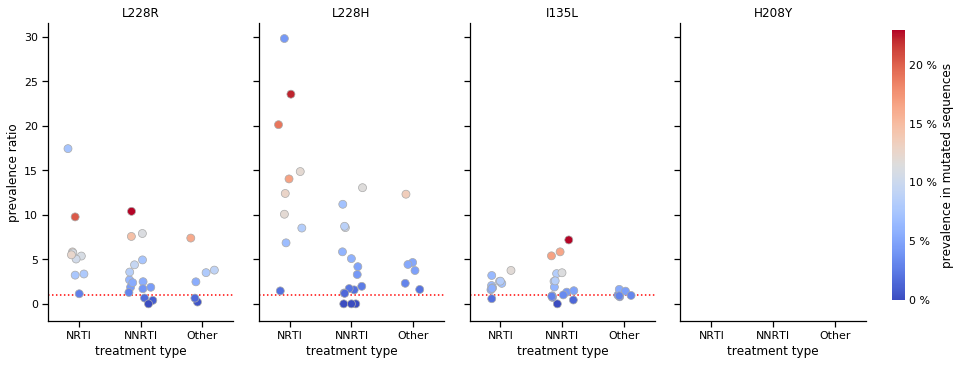

In [51]:
# color map Africa
norm = mpl.colors.Normalize(vmin=all_melted_africa['positive prevalence'].min(), vmax=all_melted_africa['positive prevalence'].max())
cmap = mpl.cm.coolwarm
colors = {round(k,6):v for k,v in zip(all_melted_africa['value'], cmap(norm(all_melted_africa['positive prevalence'].values)))}

grid = (sns.FacetGrid(data=all_melted_africa, col='index', col_order=x_order[:2] + x_order[-3:-1], aspect=0.6, height=5)
    .map_dataframe(sns.stripplot, x='group', y='value', order=treatment_order, size=8, jitter=0.2, linewidth=0.7, edgecolor="#aaaaaa")
    .map(plt.axhline, y=1, ls=':', color='red', zorder=0.5)
    .set_titles(template="{col_name}")
    .set_axis_labels('treatment type', 'prevalence ratio')
    .add_legend()
)
# correct facet titles + change color based on prevalence
for ax in grid.axes.flatten():
    for collection in ax.collections:
        offsets = collection.get_offsets()
        collection.set_facecolors([colors.get(round(y,6)) for _, y in offsets])
    ax.set_title(corresp.get(ax.get_title()))

cax = grid.fig.add_axes([1.01, 0.15, 0.015, 0.75])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='prevalence in mutated sequences')
cb.outline.set_visible(False)
cb.ax.set_yticklabels([f"{x * 100:.0f} %" for x in cb.get_ticks()])
cb.ax.tick_params(axis='both', which='both', length=0)
plt.savefig(os.path.join(dirname, 'Africa_ratios_positive_prevalence.pdf'), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

# Detailed ratio figures for UK

In [52]:
to_concat = []
cols = set(uk_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_ratios(uk_data, mut, True))
positive_prevalence_uk = pd.concat(to_concat, axis=1)

subset_prevalence_uk = positive_prevalence_uk.filter(uk_valid_drms, axis=1).filter(uk_valid_new, axis=0)
prevalence_melted_uk = pd.melt(subset_prevalence_uk.reset_index(), id_vars='index')
prevalence_melted_uk['group'] = prevalence_melted_uk['variable'].apply(get_drm_type)

In [53]:
to_concat = []
cols = set(uk_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_inter_count(uk_data, mut))
positive_counts_uk = pd.concat(to_concat, axis=1)

subset_counts_uk = positive_counts_uk.filter(uk_valid_drms, axis=1).filter(uk_valid_new, axis=0)
counts_melted_uk = pd.melt(subset_counts_uk.reset_index(), id_vars='index')
counts_melted_uk['group'] = counts_melted_uk['variable'].apply(get_drm_type)

In [54]:
indexer = ['index', 'variable', 'group']
all_melted_uk = pd.concat([
    subset_melted.set_index(indexer),
    prevalence_melted_uk.set_index(indexer).rename({'value':'positive prevalence'}, axis=1),
    counts_melted_uk.set_index(indexer).rename({'value':'count'}, axis=1)
], axis=1).reset_index()
all_melted_uk['drm prevalence'] = all_melted_uk['variable'].apply(lambda x: drm_prevs['UK'].loc[x])

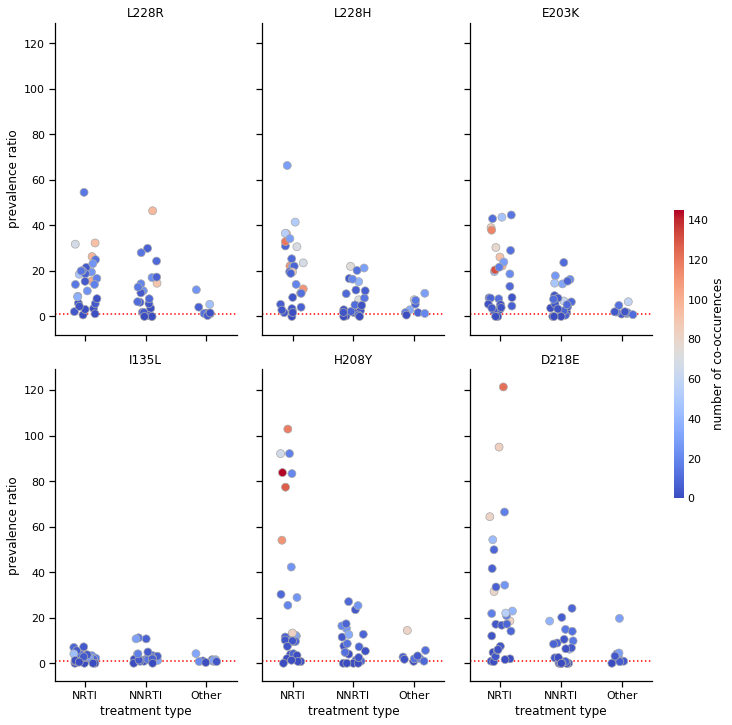

In [55]:
# color map UK
norm = mpl.colors.Normalize(vmin=all_melted_uk['count'].min(), vmax=all_melted_uk['count'].max())
cmap = mpl.cm.coolwarm
colors = {round(k,6):v for k,v in zip(all_melted_uk['value'], cmap(norm(all_melted_uk['count'].values)))}

grid = (sns.FacetGrid(data=all_melted_uk, col='index', col_order=x_order, aspect=0.6, height=5, col_wrap=3)
    .map_dataframe(sns.stripplot, x='group', y='value', order=treatment_order, size=8, jitter=0.2, linewidth=0.7, edgecolor="#aaaaaa")
    .map(plt.axhline, y=1, ls=':', color='red', zorder=0.5)
    .set_titles(template="{col_name}")
    .set_axis_labels('treatment type', 'prevalence ratio')
    .add_legend()
)
# correct facet titles + change color based on prevalence
for ax in grid.axes.flatten():
    for collection in ax.collections:
        offsets = collection.get_offsets()
        collection.set_facecolors([colors.get(round(y,6)) for _, y in offsets])
    ax.set_title(corresp.get(ax.get_title()))

cax = grid.fig.add_axes([1.01, 0.3, 0.015, 0.4])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='number of co-occurences')
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both', length=0)
plt.savefig(os.path.join(dirname, 'UK_ratios_intersection_count.pdf'), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

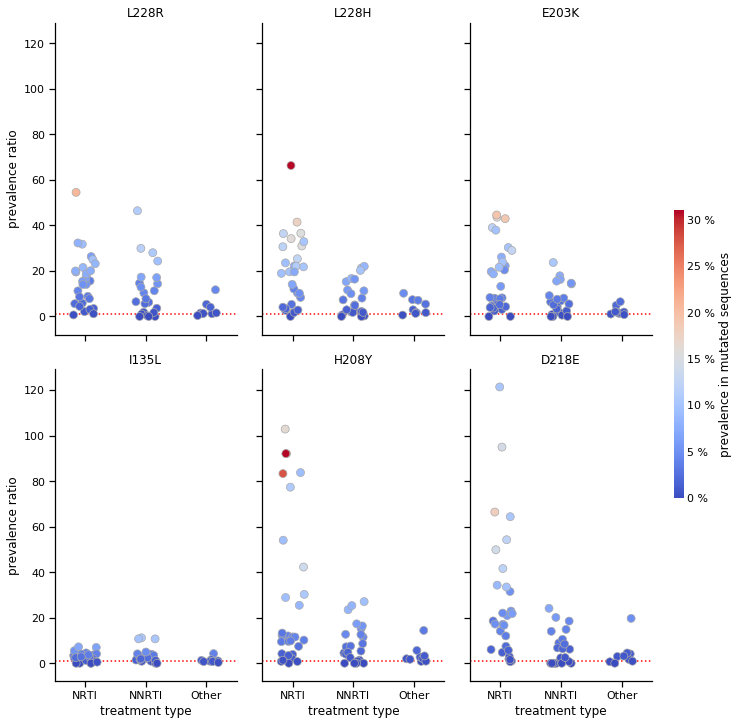

In [56]:
# color map UK
norm = mpl.colors.Normalize(vmin=all_melted_uk['positive prevalence'].min(), vmax=all_melted_uk['positive prevalence'].max())
cmap = mpl.cm.coolwarm
colors = {round(k,6):v for k,v in zip(all_melted_uk['value'], cmap(norm(all_melted_uk['positive prevalence'].values)))}

grid = (sns.FacetGrid(data=all_melted_uk, col='index', col_order=x_order, aspect=0.6, height=5, col_wrap=3)
    .map_dataframe(sns.stripplot, x='group', y='value', order=treatment_order, size=8, jitter=0.2, linewidth=0.7, edgecolor="#aaaaaa")
    .map(plt.axhline, y=1, ls=':', color='red', zorder=0.5)
    .set_titles(template="{col_name}")
    .set_axis_labels('treatment type', 'prevalence ratio')
    .add_legend()
)
# correct facet titles + change color based on prevalence
for ax in grid.axes.flatten():
    for collection in ax.collections:
        offsets = collection.get_offsets()
        collection.set_facecolors([colors.get(round(y,6)) for _, y in offsets])
    ax.set_title(corresp.get(ax.get_title()))

cax = grid.fig.add_axes([1.01, 0.3, 0.015, 0.4])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='prevalence in mutated sequences')
cb.outline.set_visible(False)
cb.ax.set_yticklabels([f"{x * 100:.0f} %" for x in cb.get_ticks()])
cb.ax.tick_params(axis='both', which='both', length=0)
plt.savefig(os.path.join(dirname, 'UK_ratios_positive_prevalence.pdf'), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

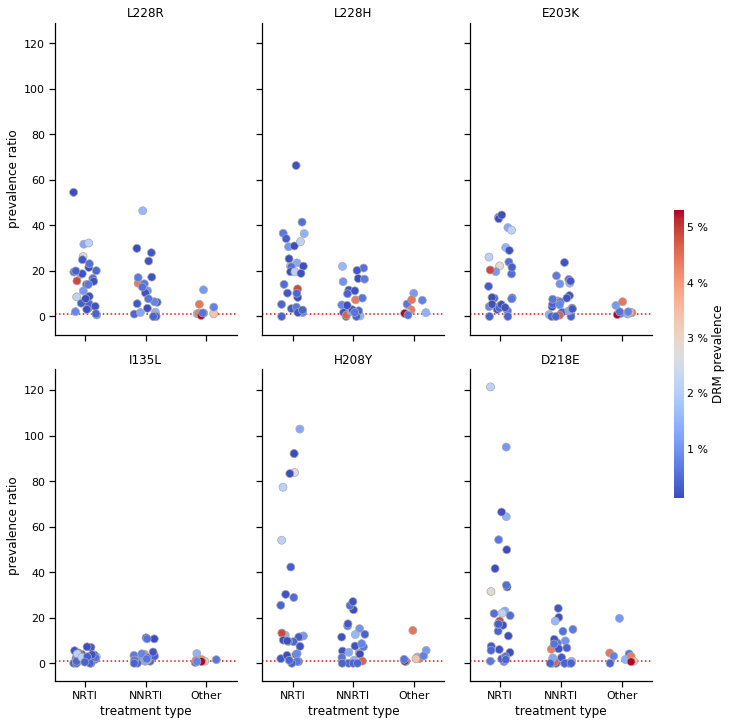

In [57]:
# color map UK
norm = mpl.colors.Normalize(vmin=all_melted_uk['drm prevalence'].min(), vmax=all_melted_uk['drm prevalence'].max())
cmap = mpl.cm.coolwarm
colors = {round(k,6):v for k,v in zip(all_melted_uk['value'], cmap(norm(all_melted_uk['drm prevalence'].values)))}

grid = (sns.FacetGrid(data=all_melted_uk, col='index', col_order=x_order, aspect=0.6, height=5, col_wrap=3)
    .map_dataframe(sns.stripplot, x='group', y='value', order=treatment_order, size=8, jitter=0.2, linewidth=0.7, edgecolor="#aaaaaa")
    .map(plt.axhline, y=1, ls=':', color='red', zorder=0.5)
    .set_titles(template="{col_name}")
    .set_axis_labels('treatment type', 'prevalence ratio')
    .add_legend()
)
# correct facet titles + change color based on prevalence
for ax in grid.axes.flatten():
    for collection in ax.collections:
        offsets = collection.get_offsets()
        collection.set_facecolors([colors.get(round(y,6)) for _, y in offsets])
    ax.set_title(corresp.get(ax.get_title()))

cax = grid.fig.add_axes([1.01, 0.3, 0.015, 0.4])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='DRM prevalence')
cb.outline.set_visible(False)
cb.ax.set_yticklabels([f"{x * 100:.0f} %" for x in cb.get_ticks()])
cb.ax.tick_params(axis='both', which='both', length=0)
plt.savefig(os.path.join(dirname, 'UK_ratios_DRM_prevalence.pdf'), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

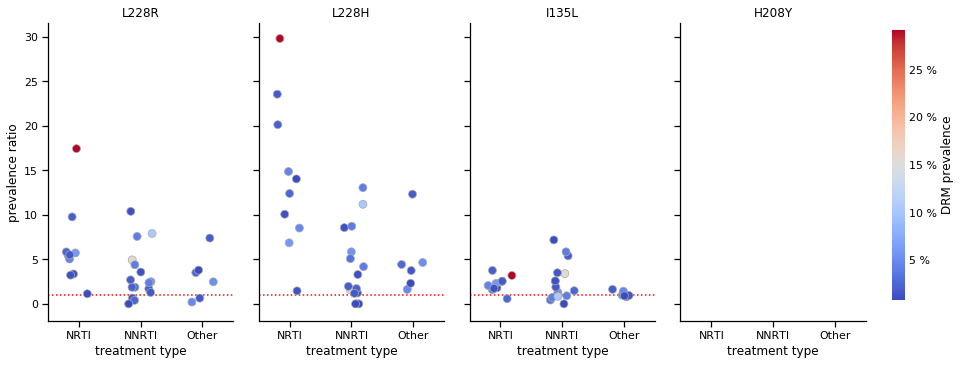

In [58]:
# color map Africa
norm = mpl.colors.Normalize(vmin=all_melted_africa['drm prevalence'].min(), vmax=all_melted_africa['drm prevalence'].max())
cmap = mpl.cm.coolwarm
colors = {round(k,6):v for k,v in zip(all_melted_africa['value'], cmap(norm(all_melted_africa['drm prevalence'].values)))}

grid = (sns.FacetGrid(data=all_melted_africa, col='index', col_order=x_order[:2] + x_order[-3:-1], aspect=0.6, height=5)
    .map_dataframe(sns.stripplot, x='group', y='value', order=treatment_order, size=8, jitter=0.2, linewidth=0.7, edgecolor="#aaaaaa")
    .map(plt.axhline, y=1, ls=':', color='red', zorder=0.5)
    .set_titles(template="{col_name}")
    .set_axis_labels('treatment type', 'prevalence ratio')
    .add_legend()
)
# correct facet titles + change color based on prevalence
for ax in grid.axes.flatten():
    for collection in ax.collections:
        offsets = collection.get_offsets()
        collection.set_facecolors([colors.get(round(y,6)) for _, y in offsets])
    ax.set_title(corresp.get(ax.get_title()))

cax = grid.fig.add_axes([1.01, 0.15, 0.015, 0.75])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='DRM prevalence')
cb.outline.set_visible(False)
cb.ax.set_yticklabels([f"{x * 100:.0f} %" for x in cb.get_ticks()])
cb.ax.tick_params(axis='both', which='both', length=0)
plt.savefig(os.path.join(dirname, 'Africa_ratios_DRM_prevalence.pdf'), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

# Confidence intervals

In [59]:
def get_CI_numpy(data, mut, n_boot=1000, level=0.95, func=compute_ratio):
    onesided = (1 - level) / 2
    open_index, close_index = round(n_boot * onesided), round(n_boot * (1 - onesided))
    boostrap_estimates = []
    subset = data.filter(list(common_features) + [mut], axis=1)
    ratios = numpy_version(subset.values, mut, func)
    for i in range(n_boot):
        boostrap_samples = subset.sample(frac=1, replace=True)
        boostrap_estimates.append(
            numpy_version(boostrap_samples.values, mut, func)
        )
    total_res = defaultdict(list)
    for l in boostrap_estimates:
        for k,v in l.items():
            total_res[k].append(v)

    subsetter = lambda x: (x[open_index], x[close_index])
    return {k:(ratios[k], subsetter(sorted(v))) for k,v in total_res.items()}

In [103]:
# to_concat = []
# cols = set(uk_data.columns.tolist())
# for mut in list(drms['ALL']) + list(drms.keys()) + targets:
#     if mut not in cols:
#         continue
#     to_concat.append(
#         pd.Series(get_CI_numpy(uk_data, mut), name=mut))
# drm_ratio_CIs = pd.concat(to_concat, axis=1)
# drm_ratio_CIs.to_csv(os.path.join(dirname, 'DRM_ratio_CIs.tsv'), sep='\t')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [104]:
# to_concat_africa = []
# cols = set(africa_data.columns.tolist())
# for mut in list(drms['ALL']) + list(drms.keys()) + targets:
#     if mut not in cols:
#         continue
#     to_concat_africa.append(
#         pd.Series(get_CI_numpy(africa_data, mut), name=mut))
# drm_ratio_CIs_africa = pd.concat(to_concat_africa, axis=1)
# drm_ratio_CIs_africa.to_csv(os.path.join(dirname, 'DRM_ratio_CIs_africa.tsv'), sep='\t')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [62]:
# melted_CIs = pd.melt(
#     drm_ratio_CIs
#         .filter(uk_valid_drms, axis=1)
#         .filter(uk_valid_new, axis=0)
#         .reset_index(), 
#     id_vars='index')
# melted_CIs['ratio'] = melted_CIs['value'].apply(lambda x: x[0])
# melted_CIs['lower'] = melted_CIs['value'].apply(lambda x: x[1][0]) 
# melted_CIs['higher'] = melted_CIs['value'].apply(lambda x: x[1][1])
# melted_CIs['group'] = melted_CIs['variable'].apply(get_drm_type)

In [63]:
# melted_CIs_africa = pd.melt(
#     drm_ratio_CIs_africa
#         .filter(africa_valid_drms, axis=1)
#         .filter(africa_valid_new, axis=0)
#         .reset_index(), 
#     id_vars='index')
# melted_CIs_africa['ratio'] = melted_CIs_africa['value'].apply(lambda x: x[0])
# melted_CIs_africa['lower'] = melted_CIs_africa['value'].apply(lambda x: x[1][0]) 
# melted_CIs_africa['higher'] = melted_CIs_africa['value'].apply(lambda x: x[1][1])
# melted_CIs_africa['group'] = melted_CIs_africa['variable'].apply(get_drm_type)

In [64]:
# to_concat = []
# for name, df in {'UK':melted_CIs, 'Africa':melted_CIs_africa}.items():
#     sub = df.drop('value', axis=1)
#     sub['dataset'] = name
#     to_concat.append(sub)
# pd.concat(to_concat).to_csv(os.path.join(dirname, 'DRM_ratios.tsv'), sep='\t')

In [65]:
concated_joined_ratios = pd.read_csv(os.path.join(dirname, 'DRM_ratios.tsv'), sep='\t', index_col=0).drop_duplicates()
melted_CIs = concated_joined_ratios[concated_joined_ratios['dataset'] == 'UK']
melted_CIs_africa = concated_joined_ratios[concated_joined_ratios['dataset'] == 'Africa']
drm_ratio_CIs = pd.read_csv(os.path.join(dirname, 'DRM_ratio_CIs.tsv'), sep='\t')
drm_ratio_CIs_africa = pd.read_csv(os.path.join(dirname, 'DRM_ratio_CIs_africa.tsv'), sep='\t')

In [66]:
def plot_vlines(**kwargs):
    data = (kwargs.pop('data').sort_values(by='lower', ascending=False)
                .reset_index(drop=True)
                .reset_index()
                .rename({'level_0': 'x'}, axis=1))
    annotate = kwargs.pop('annotate', True)
    font_dict = kwargs.pop('font_kws', dict(verticalalignment='bottom', horizontalalignment='left'))
    lower_bound = kwargs.pop('lower_bound', 5)
    text_y_offset = kwargs.pop('text_y_offset', 5)
    max_posy = kwargs.pop('max_posy', 180)
    size = kwargs.pop('size', 60)
    kwargs.pop('color', None)
    colors = sns.color_palette('muted')
    hue_order = ['NRTI', 'NNRTI', 'Other']
    markers = ['o', 's', 'D']

    # Deal with infinite ratios:
    for colname in ['ratio', 'higher', 'lower']:
        data[colname] = data[colname].apply(lambda x: max_posy if np.isinf(x) else x)

    ax = sns.scatterplot(data=data, x='x', y='ratio', hue='group', style='group', style_order=hue_order, markers=markers, 
                         edgecolor='k', zorder=1, hue_order=hue_order, s=size)
    ax.vlines(data['x'], data['lower'], data['higher'], zorder=0.9)
    if not annotate: return ax
    for _, row in data.iterrows():
        if row['lower'] < lower_bound: continue
        ax.text(row['x'], row['higher'] + text_y_offset, row['variable'].replace('_',''), rotation=90, **font_dict)
    return ax

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


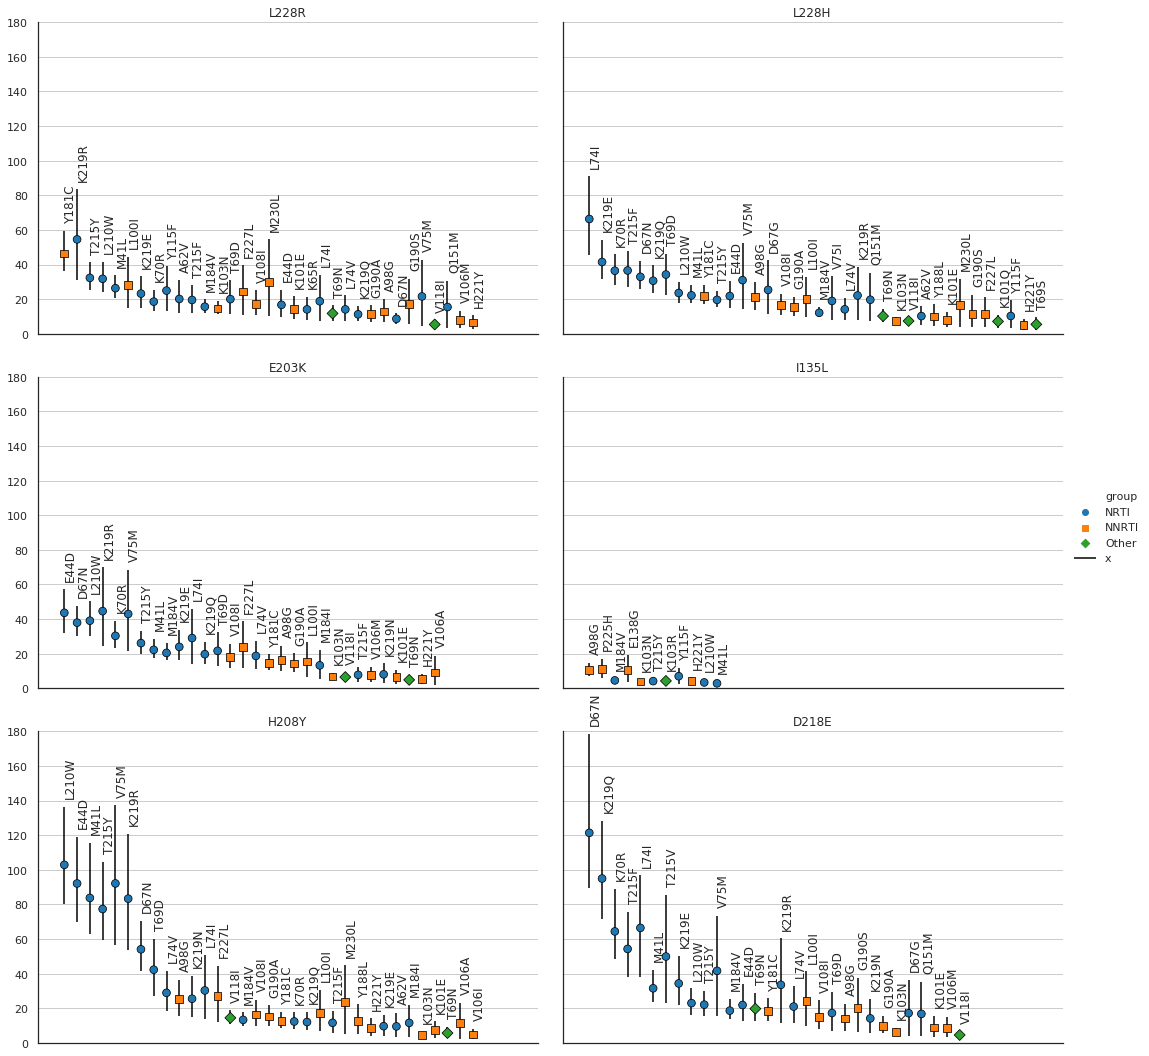

In [67]:
to_plot = melted_CIs[
    (melted_CIs['variable'].isin(drms['ALL'])) & 
    (melted_CIs['lower'] > 2)
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.5, col_order=x_labels)
                .map_dataframe(plot_vlines, lower_bound=2)
                .add_legend()
                .set_titles(template="{col_name}")
                .set(ylim=(0, 180))
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)

grid.savefig(os.path.join(dirname, "UK_ratio_bars.pdf"), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


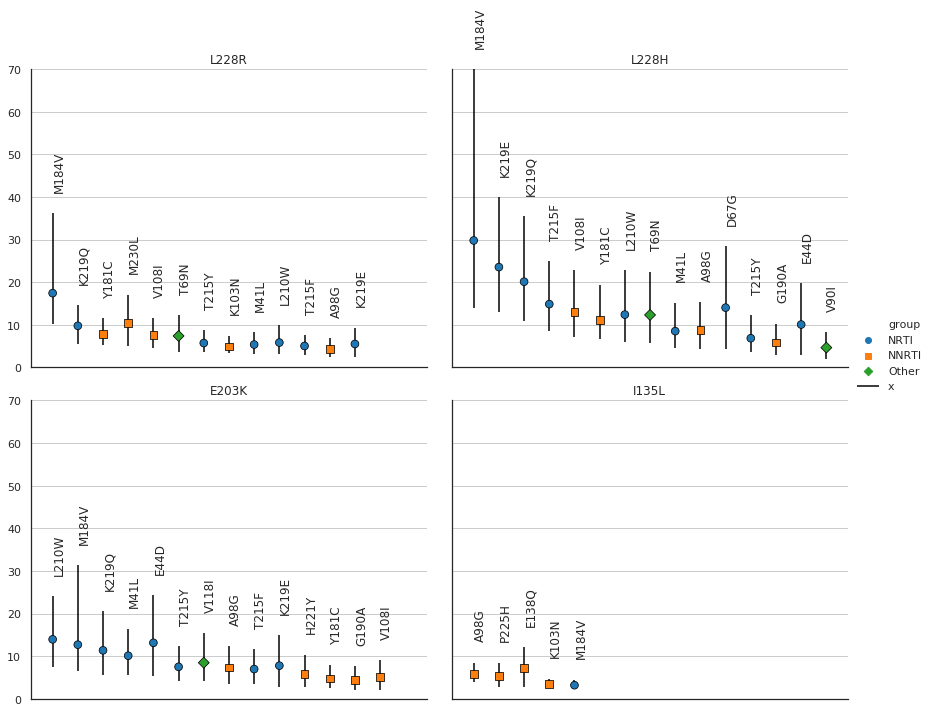

In [68]:
to_plot = melted_CIs_africa[
    (melted_CIs_africa['variable'].isin(drms['ALL'])) & 
    (melted_CIs_africa['lower'] > 2)
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.2, 
                            col_order=x_labels[:4])
                .map_dataframe(plot_vlines, max_posy=70, lower_bound=2)
                .set(ylim=(0,70))
                .set_titles(template="{col_name}")
                .add_legend()
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)
grid.savefig(os.path.join(dirname, "Africa_ratio_bars.pdf"), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

# Combining Africa and UK in same plot

In [69]:
def extract_value(series):
    return series.iloc[0] if len(series) > 0 else np.nan

In [119]:
def plot_vlines_both(**kwargs):
    data = kwargs.pop('data')
    annotate = kwargs.pop('annotate', True)
    font_dict = kwargs.pop('font_kws', dict(verticalalignment='bottom', horizontalalignment='center'))
    lower_bound = kwargs.pop('lower_bound', 5)
    text_y_offset = kwargs.pop('text_y_offset', 5)
    max_posy = kwargs.pop('max_posy', 180)
    size = kwargs.pop('size', 60)
    offset = kwargs.pop('offset', 0.2)
    kwargs.pop('color', None)
    colors = sns.color_palette('muted')
    hue_order = ['NRTI', 'NNRTI', 'Other']
    markers = ['o', 'D']

    # Deal with infinite ratios:
    for colname in ['ratio', 'higher', 'lower']:
        data[colname] = data[colname].apply(lambda x: max_posy if np.isinf(x) else x)

    data_africa = data[data['dataset'] == 'Africa']
    data_uk = data[data['dataset'] == 'UK']

    data_uk = (data_uk.sort_values(by='lower', ascending=False)
                      .reset_index(drop=True)
                      .reset_index()
                      .rename({'level_0':'x'}, axis=1))

    data_africa['x'] = data_africa['variable'].apply(lambda x: extract_value(data_uk[data_uk['variable']==x]['x'])).dropna()

    data_uk['x'], data_africa['x'] = data_uk['x'] - offset, data_africa['x'] + offset

    data_uk = data_uk.join(data_africa.set_index('variable')['higher'], on='variable', rsuffix='Africa')
    data_uk['maxHigher'] = data_uk.apply(lambda row: max(row['higher'], row['higherAfrica']), axis=1)

    for shape, subset in zip(markers, [data_uk, data_africa]):
        ax = sns.scatterplot(data=subset, x='x', y='ratio', hue='group', style_order=hue_order, marker =shape, 
                            edgecolor='k', zorder=1, hue_order=hue_order, s=size, palette='muted')
        for color, group in zip(colors, hue_order):
            subsubset = subset[subset['group'] == group]
            ax.vlines(subsubset['x'], subsubset['lower'], subsubset['higher'], zorder=0.9, color=color, label=None)

    if not annotate: return ax
    for _, row in data_uk.iterrows():
        if row['lower'] < lower_bound: continue
        ax.text(row['x']+offset, row['maxHigher'] + text_y_offset, row['variable'].replace('_',''), rotation=90, **font_dict)
    return ax

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

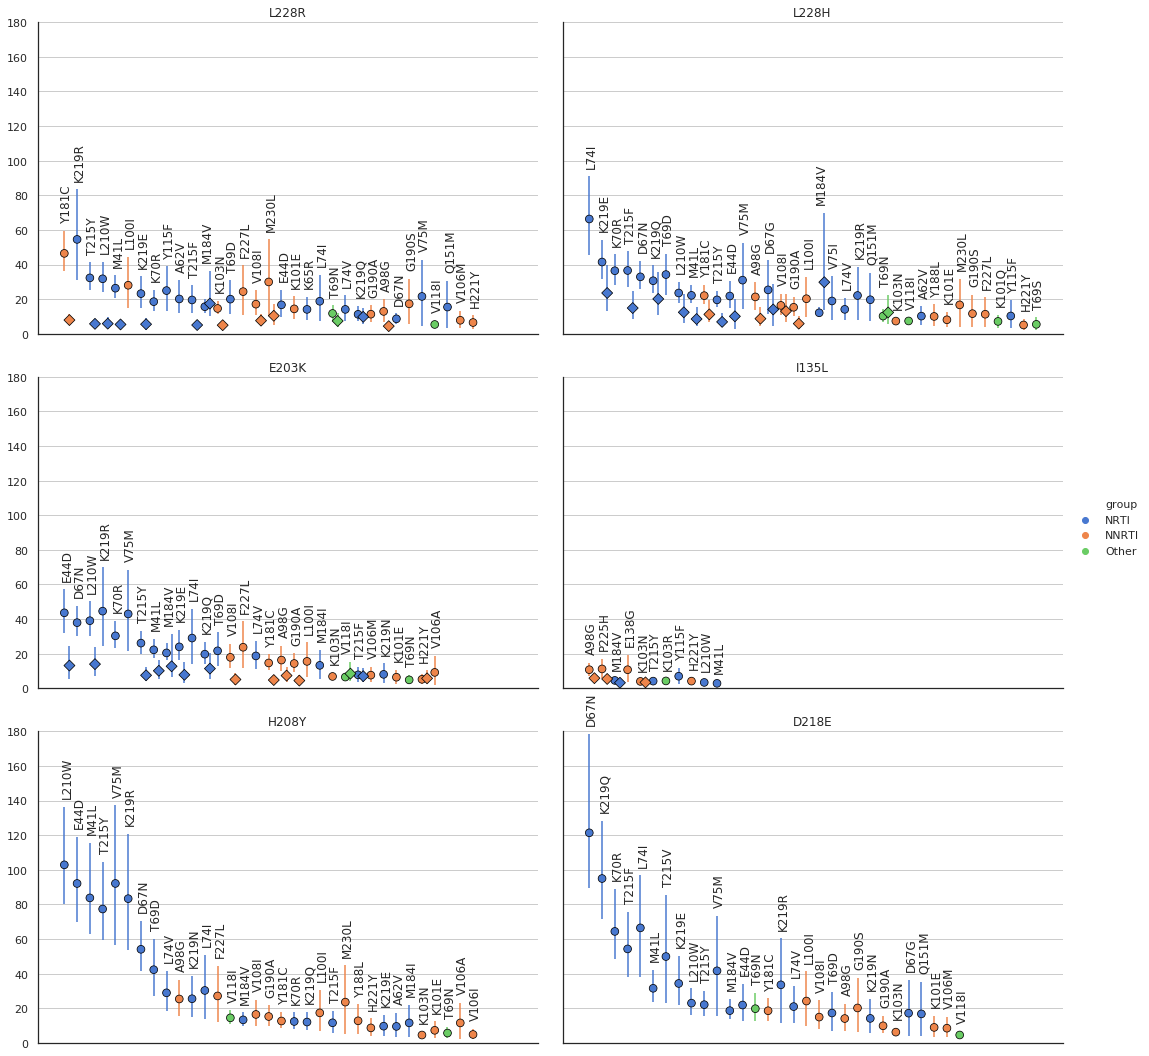

In [120]:
concated = pd.concat([melted_CIs, melted_CIs_africa], axis=0)
to_plot = concated[
    (concated['variable'].isin(drms['ALL'])) & 
    (concated['lower'] > 2)
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.5, 
                            col_order=x_labels)
                .map_dataframe(plot_vlines_both, max_posy=70, lower_bound=2)
                .set(ylim=(0,180))
                .set_titles(template="{col_name}")
                .add_legend()
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)
grid.savefig(os.path.join(dirname, "Africa_UK_ratio_bars.pdf"), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

# Co-occurence proportions

In [72]:
# to_concat = []
# cols = set(uk_data.columns.tolist())
# for mut in list(drms['ALL']) + list(drms.keys()) + targets:
#     if mut not in cols:
#         continue
#     to_concat.append(
#         pd.Series(get_CI_numpy(uk_data, mut, func=compute_cooccurrence_prop), name=mut))
# prevalence_prop_CIs = pd.concat(to_concat, axis=1)

In [73]:
# to_concat = []
# cols = set(uk_data.columns.tolist())
# for mut in list(drms['ALL']) + list(drms.keys()) + targets:
#     if mut not in cols:
#         continue
#     to_concat.append(
#         pd.Series(get_CI_numpy(africa_data, mut, func=compute_cooccurrence_prop), name=mut))
# prevalence_prop_CIs_africa = pd.concat(to_concat, axis=1)

In [74]:
# melted_prop_CIs = pd.melt(
#     prevalence_prop_CIs
#         .filter(uk_valid_drms, axis=1)
#         .filter(uk_valid_new, axis=0)
#         .reset_index(), 
#     id_vars='index')
# melted_prop_CIs['ratio'] = melted_prop_CIs['value'].apply(lambda x: x[0])
# melted_prop_CIs['lower'] = melted_prop_CIs['value'].apply(lambda x: x[1][0]) 
# melted_prop_CIs['higher'] = melted_prop_CIs['value'].apply(lambda x: x[1][1])
# melted_prop_CIs['group'] = melted_prop_CIs['variable'].apply(get_drm_type)

In [75]:
# melted_prop_CIs_africa = pd.melt(
#     prevalence_prop_CIs_africa
#         .filter(africa_valid_drms, axis=1)
#         .filter(africa_valid_new, axis=0)
#         .reset_index(), 
#     id_vars='index')
# melted_prop_CIs_africa['ratio'] = melted_prop_CIs_africa['value'].apply(lambda x: x[0])
# melted_prop_CIs_africa['lower'] = melted_prop_CIs_africa['value'].apply(lambda x: x[1][0]) 
# melted_prop_CIs_africa['higher'] = melted_prop_CIs_africa['value'].apply(lambda x: x[1][1])
# melted_prop_CIs_africa['group'] = melted_prop_CIs_africa['variable'].apply(get_drm_type)

In [76]:
# to_concat = []
# for name, df in {'UK':melted_prop_CIs, 'Africa':melted_prop_CIs_africa}.items():
#     sub = df.drop('value', axis=1)
#     sub['dataset'] = name
#     to_concat.append(sub)
# pd.concat(to_concat).to_csv(os.path.join(dirname, 'DRM_prevalence_proportions.tsv'), sep='\t')

In [77]:
concated_joined_props = pd.read_csv(os.path.join(dirname, 'DRM_prevalence_proportions.tsv'), sep='\t', index_col=0).drop_duplicates()
melted_prop_CIs = concated_joined_props[concated_joined_props['dataset'] == 'UK']
melted_prop_CIs_africa = concated_joined_props[concated_joined_props['dataset'] == 'Africa']

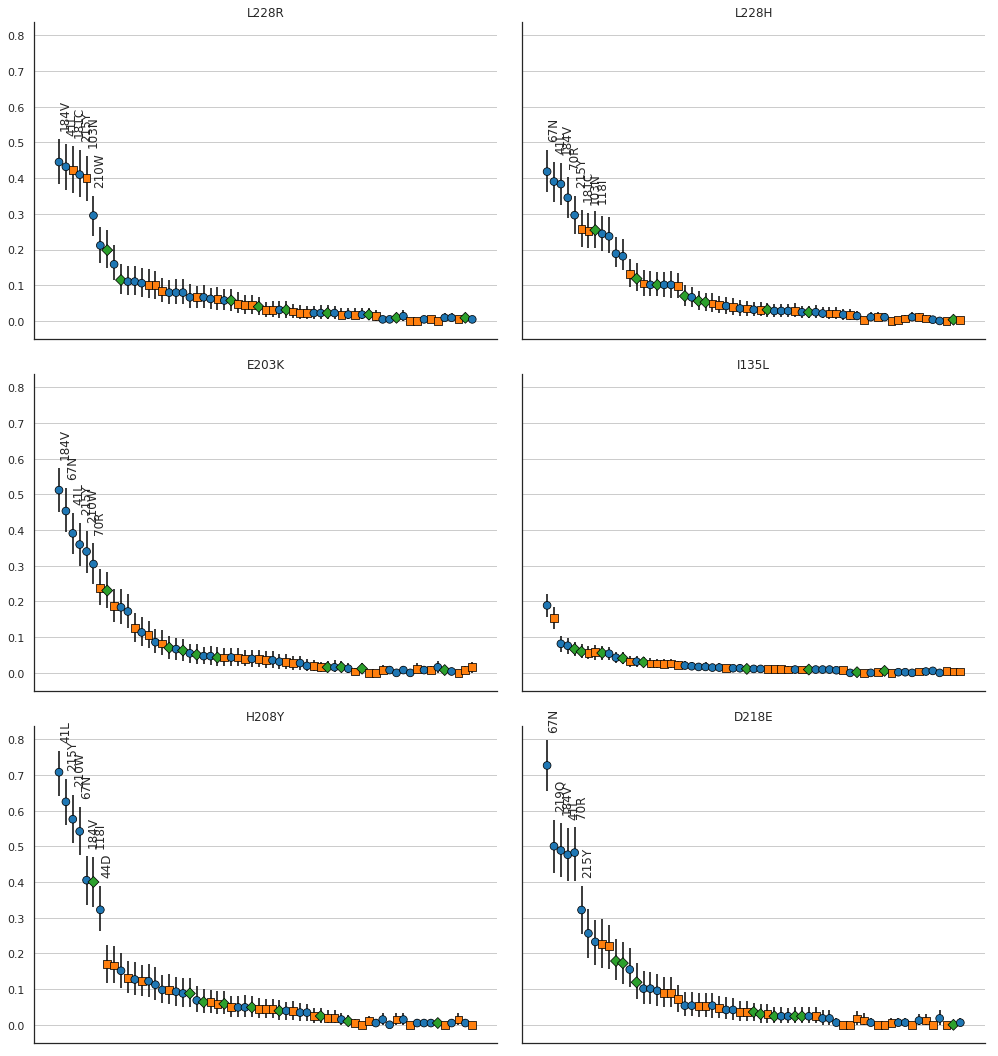

In [78]:
to_plot = melted_prop_CIs[
    melted_prop_CIs['variable'].isin(drms['ALL'])
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.4, col_order=x_labels)
                .map_dataframe(plot_vlines, lower_bound=0.2, text_y_offset=0.025)
                # .set(ylim=(0,70))
                .set_titles(template="{col_name}")
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)

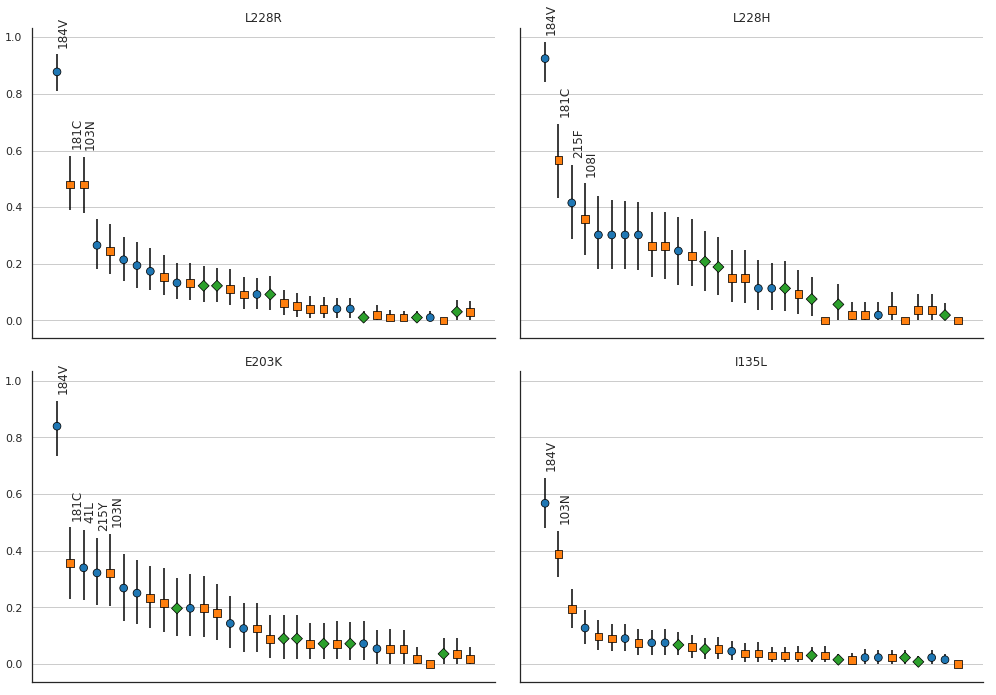

In [79]:
to_plot = melted_prop_CIs_africa[
    melted_prop_CIs_africa['variable'].isin(drms['ALL'])
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.4, col_order=x_labels[:4])
                .map_dataframe(plot_vlines, lower_bound=0.2, text_y_offset=0.025, max_posy=1)
                # .set(ylim=(0,70))
                .set_titles(template="{col_name}")
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)

# Weighted co-occurrence proportion

In [80]:
to_concat = []
cols = set(uk_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(
        pd.Series(get_CI_numpy(uk_data, mut, func=compute_weighted_cooccurrence_prop), name=mut))
weighted_prevalence_prop_CIs = pd.concat(to_concat, axis=1)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [81]:
to_concat = []
cols = set(uk_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(
        pd.Series(get_CI_numpy(africa_data, mut, func=compute_weighted_cooccurrence_prop), name=mut))
weighted_prevalence_prop_CIs_africa = pd.concat(to_concat, axis=1)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [82]:
melted_weighted_prop_CIs = pd.melt(
    weighted_prevalence_prop_CIs
        .filter(uk_valid_drms, axis=1)
        .filter(uk_valid_new, axis=0)
        .reset_index(), 
    id_vars='index')
melted_weighted_prop_CIs['ratio'] = melted_weighted_prop_CIs['value'].apply(lambda x: x[0])
melted_weighted_prop_CIs['lower'] = melted_weighted_prop_CIs['value'].apply(lambda x: x[1][0]) 
melted_weighted_prop_CIs['higher'] = melted_weighted_prop_CIs['value'].apply(lambda x: x[1][1])
melted_weighted_prop_CIs['group'] = melted_prop_CIs['variable'].apply(get_drm_type)

In [83]:
melted_weighted_prop_CIs_africa = pd.melt(
    weighted_prevalence_prop_CIs_africa
        .filter(africa_valid_drms, axis=1)
        .filter(africa_valid_new, axis=0)
        .reset_index(), 
    id_vars='index')
melted_weighted_prop_CIs_africa['ratio'] = melted_weighted_prop_CIs_africa['value'].apply(lambda x: x[0])
melted_weighted_prop_CIs_africa['lower'] = melted_weighted_prop_CIs_africa['value'].apply(lambda x: x[1][0]) 
melted_weighted_prop_CIs_africa['higher'] = melted_weighted_prop_CIs_africa['value'].apply(lambda x: x[1][1])
melted_weighted_prop_CIs_africa['group'] = melted_weighted_prop_CIs_africa['variable'].apply(get_drm_type)

In [84]:
to_concat = []
for name, df in {'UK':melted_weighted_prop_CIs, 'Africa':melted_weighted_prop_CIs_africa}.items():
    sub = df.drop('value', axis=1)
    sub['dataset'] = name
    to_concat.append(sub)
pd.concat(to_concat).to_csv(os.path.join(dirname, 'DRM_weighted_prevalence_proportions.tsv'), sep='\t')

In [85]:
# concated_joined_props = pd.read_csv(os.path.join(dirname, 'DRM_prevalence_proportions.tsv'), sep='\t', index_col=0).drop_duplicates()
# melted_prop_CIs = concated_joined_props[concated_joined_props['dataset'] == 'UK']
# melted_prop_CIs_africa = concated_joined_props[concated_joined_props['dataset'] == 'Africa']

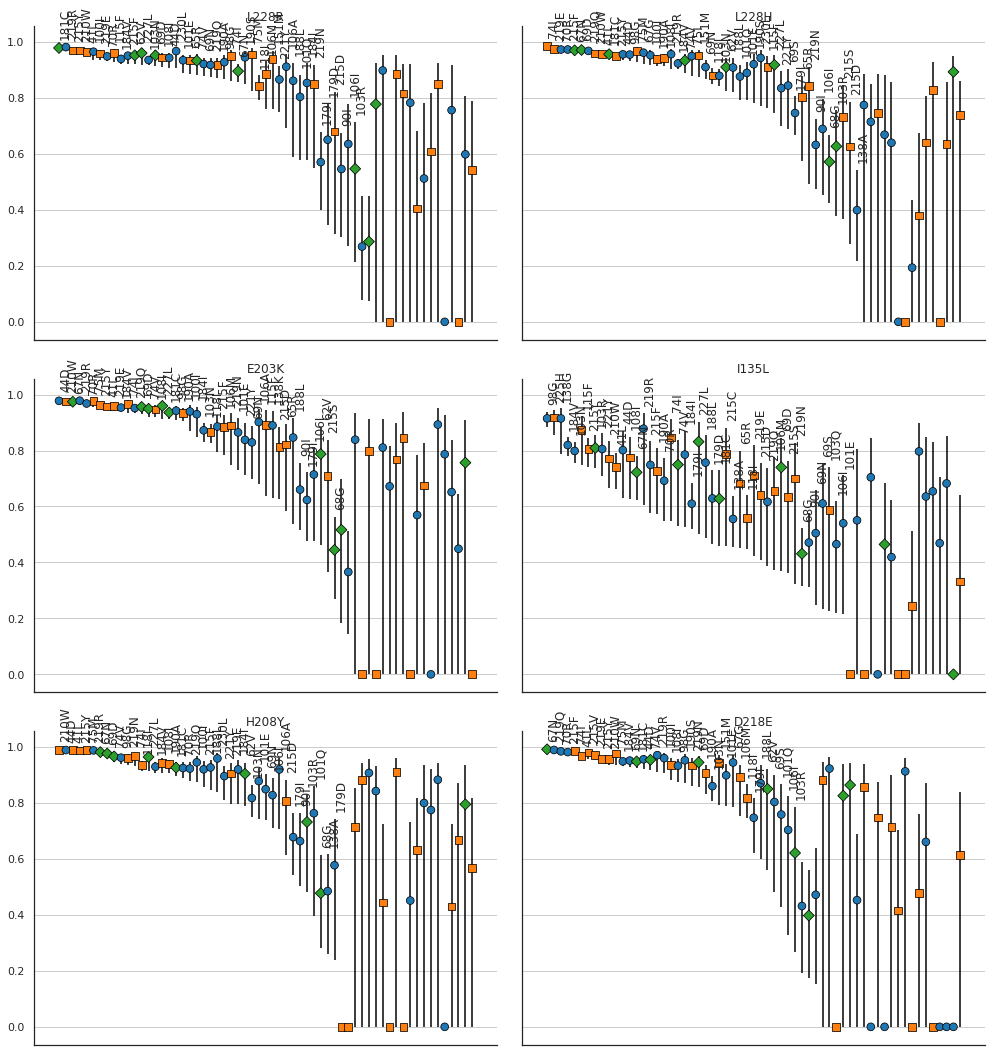

In [86]:
to_plot = melted_weighted_prop_CIs[
    melted_weighted_prop_CIs['variable'].isin(drms['ALL'])
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.4, col_order=x_labels)
                .map_dataframe(plot_vlines, lower_bound=0.2, text_y_offset=0.025)
                # .set(ylim=(0,70))
                .set_titles(template="{col_name}")
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)

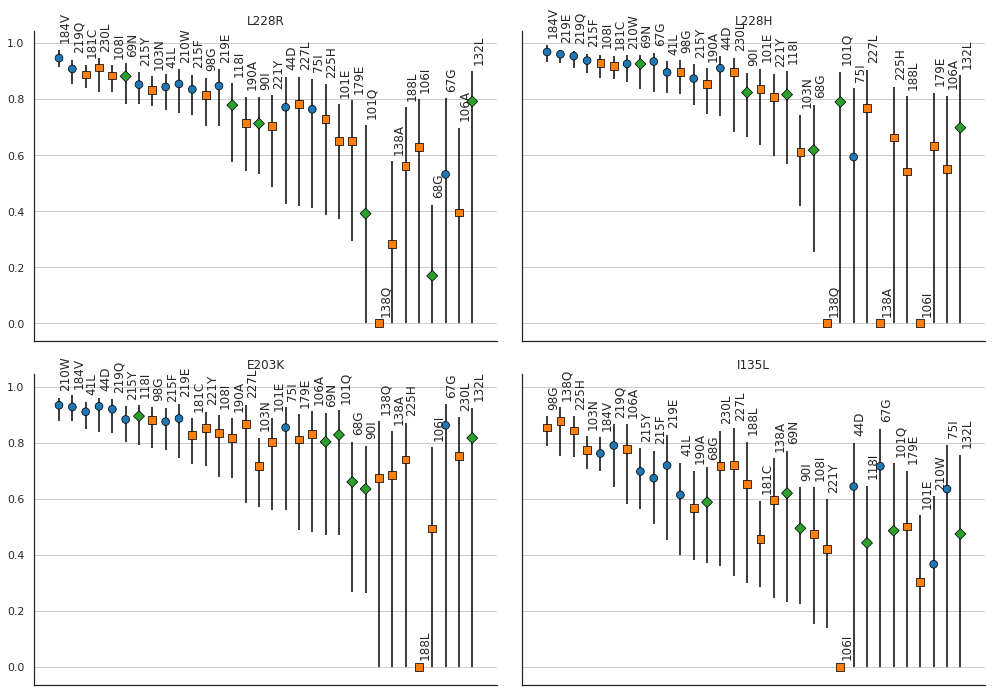

In [87]:
to_plot = melted_weighted_prop_CIs_africa[
    melted_weighted_prop_CIs_africa['variable'].isin(drms['ALL'])
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.4, col_order=x_labels[:4])
                .map_dataframe(plot_vlines, lower_bound=0, text_y_offset=0.025, max_posy=1)
                # .set(ylim=(0,70))
                .set_titles(template="{col_name}")
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)

In [88]:
get_contingency(africa_data['203_K'], africa_data['210_W'])

array([[3847,   87],
       [  41,   15]])

# Grouping both informations

In [89]:
indexer = ['index', 'variable', 'group']
renamer = lambda cols, value: {col:f"{col}_{value}" for col in cols}
joined_africa = (
    melted_CIs_africa
    .set_index(indexer)
    .rename(renamer(melted_CIs_africa.columns, 'ratio'), axis=1)
    .join(
        melted_prop_CIs_africa
            .set_index(indexer)
            .rename(renamer(melted_prop_CIs_africa, 'prevalence'), axis=1)
    )
    .reset_index()
)
joined = (
    melted_CIs
    .set_index(indexer)
    .rename(renamer(melted_CIs.columns, 'ratio'), axis=1)
    .join(
        melted_prop_CIs
            .set_index(indexer)
            .rename(renamer(melted_prop_CIs, 'prevalence'), axis=1)
    )
    .reset_index()
)

In [90]:
def plot_vlines_combined(**kwargs):
    data = (kwargs.pop('data').sort_values(by='lower_ratio', ascending=False)
                .reset_index(drop=True)
                .reset_index()
                .rename({'level_0': 'x'}, axis=1))
    annotate = kwargs.pop('annotate', True)
    font_dict = kwargs.pop('font_kws', dict(verticalalignment='bottom', horizontalalignment='left'))
    lower_bound = kwargs.pop('lower_bound', 5)
    text_y_offset = kwargs.pop('text_y_offset', 5)
    norm = kwargs.pop('norm', mpl.colors.Normalize(vmin=0, vmax=1))
    cmap = kwargs.pop('cmap', mpl.cm.coolwarm)
    size = kwargs.pop('size', 50)
    max_posy = kwargs.pop('max_posy', 180)
    kwargs.pop('color', None)

    # Deal with infinite ratios:
    for varname in ['ratio', 'higher', 'lower']:
        for vartype in ['ratio', 'prevalence']:
            colname = f"{varname}_{vartype}"
            data[colname] = data[colname].apply(lambda x: max_posy if np.isinf(x) else x)
    for group, marker in zip(['NRTI', 'NNRTI', 'Other'], ['o', 's', 'D']):
        sub = data[data['group'] == group]
        plt.scatter(x=sub['x'], y=sub['ratio_ratio'], edgecolor='k', zorder=1, c=sub['ratio_prevalence'], 
                    cmap=cmap, norm=norm, linewidths=1, s=size, marker=marker)
    plt.vlines(data['x'], data['lower_ratio'], data['higher_ratio'], zorder=0.9)
    if not annotate: return
    for _, row in data.iterrows():
        if row['lower_ratio'] < lower_bound: continue
        plt.text(row['x'], row['higher_ratio'] + text_y_offset, row['variable'].replace('_',''), rotation=90, **font_dict)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


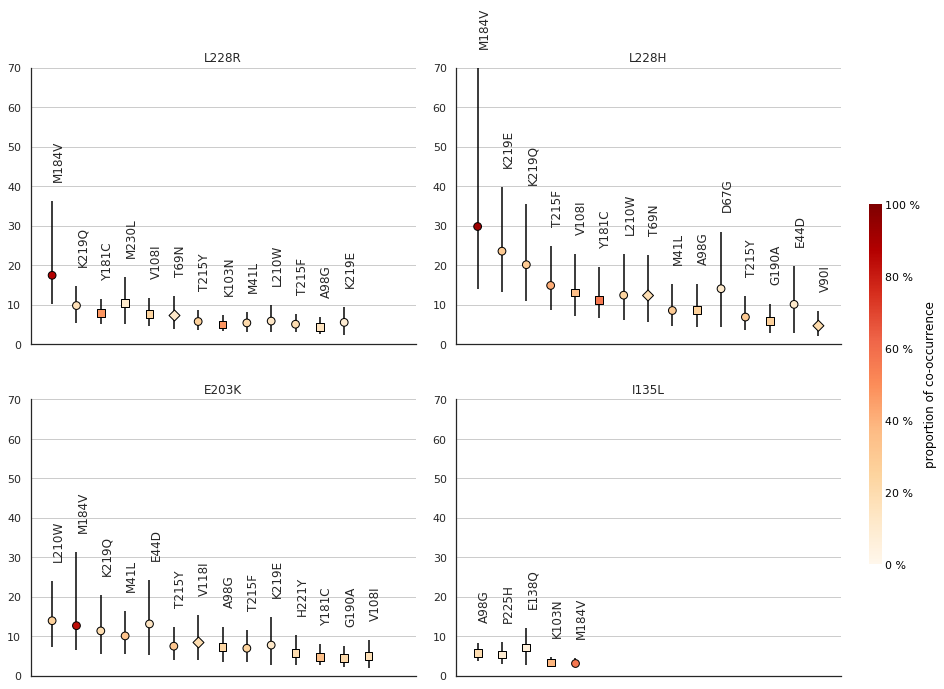

In [91]:
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = mpl.cm.OrRd

to_plot = joined_africa[
    joined_africa['lower_ratio'] > 2
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.2, sharey=False, col_order=x_labels[:4])
                .map_dataframe(plot_vlines_combined, norm=norm, cmap=cmap, size=60, max_posy=70, lower_bound=2)
                .set(ylim=(0,70))
                .set_titles(template="{col_name}")
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)
    ax.xaxis.grid(False)
cax = grid.fig.add_axes([1.01, 0.2, 0.015, 0.5])

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='proportion of co-occurrence')
cb.outline.set_visible(False)
cb.ax.set_yticklabels([f"{x * 100:.0f} %" for x in cb.get_ticks()])
cb.ax.tick_params(axis='both', which='both', length=0)
plt.subplots_adjust(hspace=0.2)
grid.savefig(os.path.join(dirname, "Africa_ratio_bars_cooccurrenec_color.pdf"), format='pdf', alpha=.99, bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


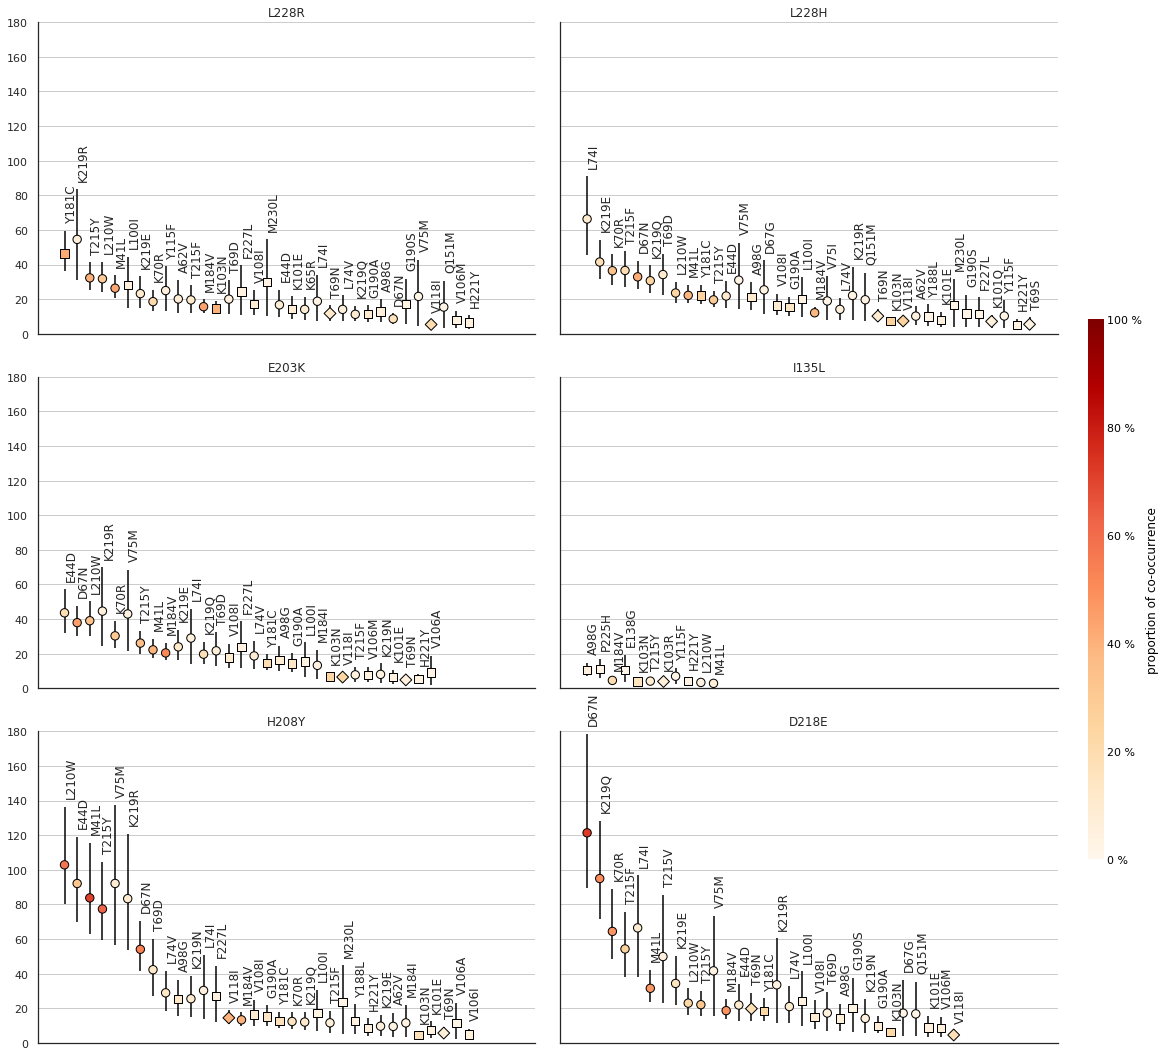

In [92]:
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = mpl.cm.OrRd

to_plot = joined[
    joined['lower_ratio'] > 2
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.5, col_order=x_labels)
                .map_dataframe(plot_vlines_combined, norm=norm, cmap=cmap, size=70, lower_bound=2)
                .set(ylim=(0,180))
                .set_titles(template="{col_name}")
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)

cax = grid.fig.add_axes([1.01, 0.2, 0.015, 0.5])

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='proportion of co-occurrence')
cb.outline.set_visible(False)
cb.ax.set_yticklabels([f"{x * 100:.0f} %" for x in cb.get_ticks()])
cb.ax.tick_params(axis='both', which='both', length=0)

grid.savefig(os.path.join(dirname, "UK{_ratio_bars_cooccurrenec_color.pdf"), format='pdf', alpha=.99, bbox_inches='tight')

# weighted grouped info

In [93]:
joined_weighted_africa = (
    melted_CIs_africa
    .set_index(indexer)
    .rename(renamer(melted_CIs_africa.columns, 'ratio'), axis=1)
    .join(
        melted_weighted_prop_CIs_africa
            .set_index(indexer)
            .rename(renamer(melted_weighted_prop_CIs_africa, 'prevalence'), axis=1)
    )
    .reset_index()
)
joined_weighted = (
    melted_CIs
    .set_index(indexer)
    .rename(renamer(melted_CIs.columns, 'ratio'), axis=1)
    .join(
        melted_weighted_prop_CIs
            .set_index(indexer)
            .rename(renamer(melted_weighted_prop_CIs, 'prevalence'), axis=1)
    )
    .reset_index()
)

In [94]:
melted_weighted_prop_CIs.set_index(indexer).rename(renamer(melted_weighted_prop_CIs.columns, 'ratio'), axis=1)

,,,value_ratio,ratio_ratio,lower_ratio,higher_ratio
index,variable,group,,,,
228_H,41_L,NNRTI,"(0.9568490859096479, (0.9458078252006875, 0.96...",0.956849,0.945808,0.965179
203_K,41_L,NNRTI,"(0.9569151527313235, (0.9447303467839281, 0.96...",0.956915,0.944730,0.966109
135_L,41_L,NNRTI,"(0.7400435956843013, (0.6635632002524854, 0.79...",0.740044,0.663563,0.790799
208_Y,41_L,NNRTI,"(0.9881980500522365, (0.9845782559808395, 0.99...",0.988198,0.984578,0.991285
218_E,41_L,NNRTI,"(0.9692287251233509, (0.9589456635318704, 0.97...",0.969229,0.958946,0.977112
...,...,...,...,...,...,...
203_K,215_E,NNRTI,"(0.0, (0.0, 0.0))",0.000000,0.000000,0.000000
135_L,215_E,NNRTI,"(0.3315179293610137, (0.0, 0.6427120060996141))",0.331518,0.000000,0.642712
208_Y,215_E,NNRTI,"(0.5671586715867158, (0.0, 0.8176045770717681))",0.567159,0.000000,0.817605


In [95]:
melted_CIs[melted_CIs['variable']=='215_S']

,index,variable,ratio,lower,higher,group,dataset
138,208_Y,215_S,0.753455,0.000000,2.489313,NRTI,UK
139,203_K,215_S,2.439758,0.545357,5.407925,NRTI,UK
140,135_L,215_S,1.727019,0.528463,3.267250,NRTI,UK
141,218_E,215_S,0.920388,0.000000,3.125580,NRTI,UK
142,228_R,215_S,0.680109,0.000000,2.420751,NRTI,UK
143,228_H,215_S,2.725261,0.564010,5.209484,NRTI,UK


In [96]:
melted_weighted_prop_CIs[melted_weighted_prop_CIs['variable']=='215_S']

,index,variable,value,ratio,lower,higher,group
78,228_H,215_S,"(0.7315624519406689, (0.3660955816050497, 0.84...",0.731562,0.366096,0.846379,NNRTI
79,203_K,215_S,"(0.7092818489144825, (0.36647729160437226, 0.8...",0.709282,0.366477,0.838455,NNRTI
80,135_L,215_S,"(0.6332992849846782, (0.36206602349543876, 0.7...",0.633299,0.362066,0.762915,NNRTI
81,208_Y,215_S,"(0.429697233989534, (0.0, 0.7244872961433472))",0.429697,0.000000,0.724487,NNRTI
82,218_E,215_S,"(0.4792717987023703, (0.0, 0.7589674025122934))",0.479272,0.000000,0.758967,NNRTI
83,228_R,215_S,"(0.4048006807811376, (0.0, 0.682234745577547))",0.404801,0.000000,0.682235,NNRTI


/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


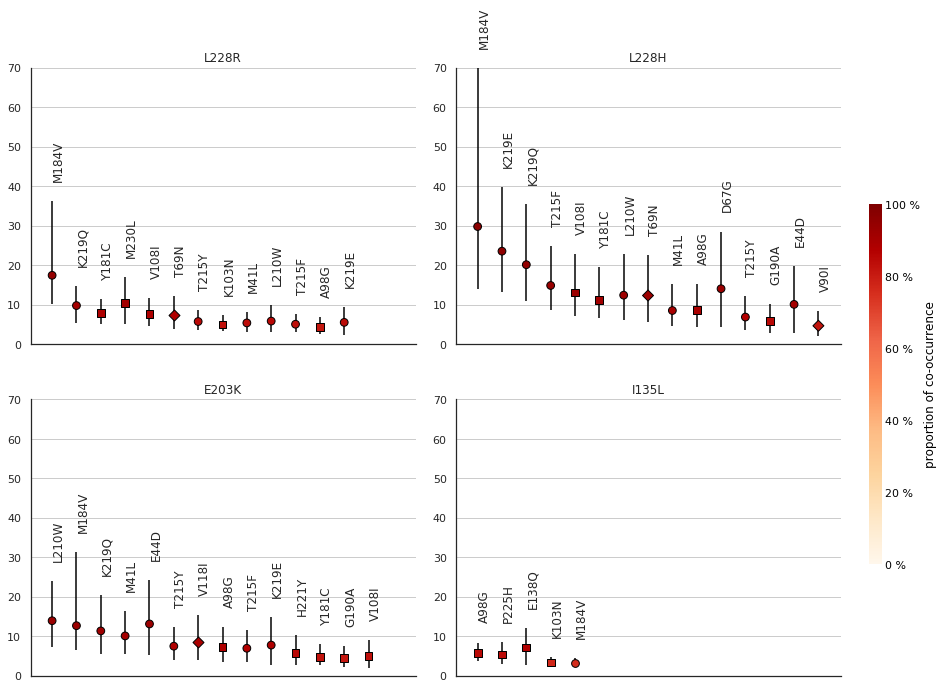

In [97]:
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = mpl.cm.OrRd

to_plot = joined_weighted_africa[
    joined_weighted_africa['lower_ratio'] > 2
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.2, sharey=False, col_order=x_labels[:4])
                .map_dataframe(plot_vlines_combined, norm=norm, cmap=cmap, size=60, max_posy=70, lower_bound=2)
                .set(ylim=(0,70))
                .set_titles(template="{col_name}")
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)
    ax.xaxis.grid(False)
cax = grid.fig.add_axes([1.01, 0.2, 0.015, 0.5])

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='proportion of co-occurrence')
cb.outline.set_visible(False)
cb.ax.set_yticklabels([f"{x * 100:.0f} %" for x in cb.get_ticks()])
cb.ax.tick_params(axis='both', which='both', length=0)
plt.subplots_adjust(hspace=0.2)
# grid.savefig(os.path.join(dirname, "Africa_ratio_bars_cooccurrenec_color.pdf"), format='pdf', alpha=.99, bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


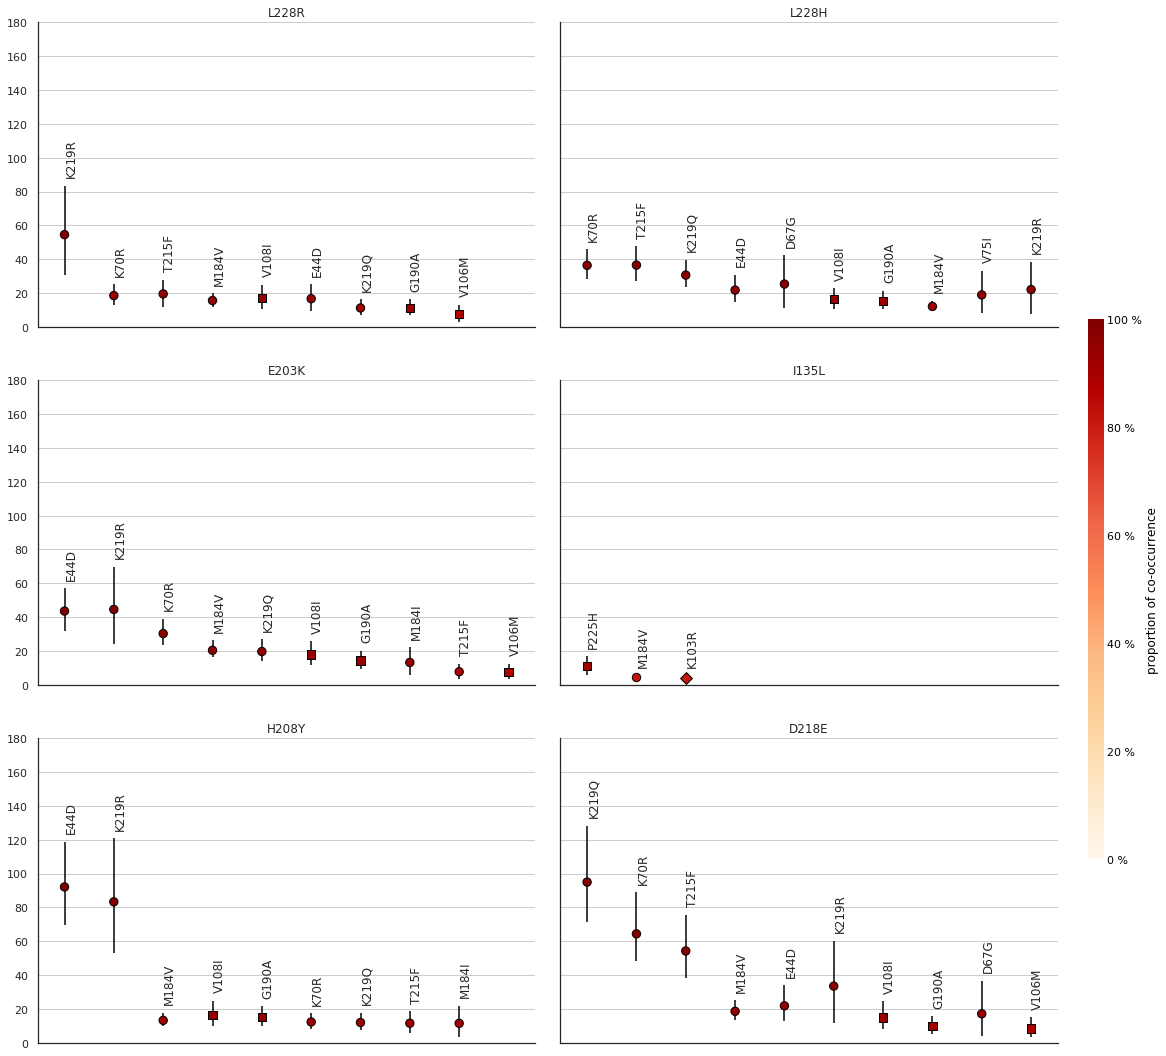

In [98]:
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = mpl.cm.OrRd

to_plot = joined_weighted[
    joined_weighted['lower_ratio'] > 2
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.5, col_order=x_labels)
                .map_dataframe(plot_vlines_combined, norm=norm, cmap=cmap, size=70, lower_bound=2)
                .set(ylim=(0,180))
                .set_titles(template="{col_name}")
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)

cax = grid.fig.add_axes([1.01, 0.2, 0.015, 0.5])

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', 
    drawedges=False, label='proportion of co-occurrence')
cb.outline.set_visible(False)
cb.ax.set_yticklabels([f"{x * 100:.0f} %" for x in cb.get_ticks()])
cb.ax.tick_params(axis='both', which='both', length=0)

# grid.savefig(os.path.join(dirname, "UK{_ratio_bars_cooccurrenec_color.pdf"), format='pdf', alpha=.99, bbox_inches='tight')

# Statistical tests

In [99]:
pvals = {}
# features = africa_data.filter(regex=r"\d+_[^X*nan-]", axis=1).columns.tolist()
for feature in common_features:
    table = (
        pd.crosstab(africa_data[feature], africa_data['encoded_label'])
        .reindex(index=[0, 1], columns=[0, 1], fill_value=0)
        .values
    )
    print(f"{feature}:\n{table}\n")
    pvals[feature] = fisher_exact(table, alternative="greater")
pval_df = pd.DataFrame.from_dict(
    pvals, orient="index", columns=["odds_ratio", "p_value"]
)
for method in ["Bonferroni", "fdr_bh", "fdr_by"]:
    _, pval_df[method], _, _ = multipletests(
        pval_df["p_value"], method=method, alpha=0.05
    )
pval_df.loc[common_features]

228_H:
[[2313 1624]
 [   3   50]]

203_K:
[[2311 1623]
 [   5   51]]

135_L:
[[2269 1587]
 [  47   87]]

208_Y:
[[2316 1661]
 [   0   13]]

218_E:
[[2316 1649]
 [   0   25]]

228_R:
[[2312 1580]
 [   4   94]]



,odds_ratio,p_value,Bonferroni,fdr_bh,fdr_by
228_H,23.737685,4.438775e-16,2.663265e-15,1.331633e-15,3.262500e-15
203_K,14.523845,1.059324e-14,6.355946e-14,2.118649e-14,5.190689e-14
135_L,2.646543,4.260436e-08,2.556262e-07,5.112523e-08,1.252568e-07
208_Y,inf,1.214467e-05,7.286800e-05,1.214467e-05,2.975443e-05
218_E,inf,3.342502e-10,2.005501e-09,5.013753e-10,1.228369e-09
228_R,34.387342,3.402140e-31,2.041284e-30,2.041284e-30,5.001146e-30


table, feature

# Table outputs for paper + datasheet

In [100]:
melted = pd.melt(drm_ratios.reset_index(), id_vars='index')
melted_africa = pd.melt(drm_ratios_africa.reset_index(), id_vars='index')

In [101]:
shapes = [africa_data.shape[0], uk_data.shape[0]]
percents = (
    new_counts.applymap(lambda x: f"{x} ") + 
    (new_counts / shapes).applymap(lambda x: f"({x*100:.1f}%)")
).loc[x_order]
percents

,Africa,UK
228_R,98 (2.5%),227 (0.4%)
228_H,53 (1.3%),287 (0.5%)
203_K,56 (1.4%),256 (0.5%)
135_L,134 (3.4%),540 (1.0%)
208_Y,13 (0.3%),205 (0.4%)
218_E,25 (0.6%),168 (0.3%)


In [109]:
pd.concat([
    drm_ratio_CIs['encoded_label'].rename('UK'),
    drm_ratio_CIs_africa['encoded_label'].rename('Africa'),
], axis=1).applymap(
    lambda x: f"{x[0]:.1f} [{x[1][0]:.1f} ; {x[1][1]:.1f}]"
).loc[x_order, ['UK', 'Africa']]

,UK,Africa
228_R,18.1 [13.2 ; 27.6],32.5 [15.1 ; 155.3]
228_H,6.4 [5.0 ; 8.3],23.1 [9.8 ; inf]
203_K,11.0 [8.2 ; 14.9],14.1 [6.9 ; 62.8]
135_L,1.8 [1.5 ; 2.1],2.6 [1.8 ; 3.7]
208_Y,8.8 [6.7 ; 12.3],inf [inf ; inf]
218_E,13.1 [9.1 ; 20.4],inf [inf ; inf]


In [110]:
pd.concat([
    drm_ratios_africa['encoded_label'].rename('Africa'),
    drm_ratios['encoded_label'].rename('UK')
], axis=1).applymap(lambda x: f"{x:.1f}").loc[x_order, ['UK', 'Africa']]

,UK,Africa
228_R,18.1,32.5
228_H,6.4,23.1
203_K,11.0,14.1
135_L,1.8,2.6
208_Y,8.8,inf
218_E,13.1,inf


In [111]:
pd.concat([
    drm_ratio_CIs['hasDRM'].rename('UK'),
    drm_ratio_CIs_africa['hasDRM'].rename('Africa'),
], axis=1).applymap(
    lambda x: f"{x[0]:.1f} [{x[1][0]:.1f} ; {x[1][1]:.1f}]"
).loc[x_order, ['UK', 'Africa']]

,UK,Africa
228_R,115.7 [51.7 ; 514.1],42.4 [18.1 ; inf]
228_H,9.2 [7.0 ; 12.6],34.1 [11.6 ; inf]
203_K,20.1 [13.8 ; 33.3],17.4 [7.8 ; 88.6]
135_L,2.4 [2.0 ; 2.8],2.4 [1.7 ; 3.4]
208_Y,14.9 [10.3 ; 24.4],inf [inf ; inf]
218_E,27.0 [15.9 ; 54.1],inf [inf ; inf]


In [112]:
pd.concat([
    drm_ratios_africa['hasDRM'].rename('Africa'),
    drm_ratios['hasDRM'].rename('UK')
], axis=1).applymap(lambda x: f"{x:.1f}").loc[x_order, ['UK', 'Africa']]

,UK,Africa
228_R,115.7,42.4
228_H,9.2,34.1
203_K,20.1,17.4
135_L,2.4,2.4
208_Y,14.9,inf
218_E,27.0,inf


# Looking at DRM type prevalence in datasets
(to check if higher ratios for NRTI are just due to an effect of prevalence)

In [113]:
for name in ['NRTI', 'NNRTI', 'Other']:
    print(name)
    print(
        pd.concat([
            uk_data.filter(drms[name], axis=1).any(axis=1).value_counts(normalize=True).rename('UK'),
            africa_data.filter(drms[name], axis=1).any(axis=1).value_counts(normalize=True).rename('Africa')
        ], axis=1)
    )
    print()

NRTI
             UK    Africa
False  0.892472  0.685464
True   0.107528  0.314536

NNRTI
             UK    Africa
False  0.840058  0.628321
True   0.159942  0.371679

Other
             UK    Africa
False  0.827239  0.841353
True   0.172761  0.158647



In [114]:
tops = (concated_joined_ratios
        .groupby(['index', 'dataset'])
        .apply(lambda x: x.sort_values(by=['lower', 'ratio'], ascending=False).iloc[:5]['variable'].values)
        .reset_index())

In [115]:
tops.pivot(index='index', columns='dataset', values=0)

dataset,Africa,UK
index,,
135_L,"[98_G, 225_H, 138_Q, 103_N, 184_V]","[98_G, 225_H, 184_V, 138_G, 103_N]"
203_K,"[210_W, 184_V, 219_Q, 41_L, 44_D]","[44_D, 67_N, 210_W, 219_R, 70_R]"
208_Y,NaN,"[210_W, 44_D, 41_L, 215_Y, 75_M]"
218_E,NaN,"[67_N, 219_Q, 70_R, 215_F, 74_I]"
228_H,"[184_V, 219_E, 219_Q, 215_F, 108_I]","[74_I, 219_E, 70_R, 215_F, 67_N]"
228_R,"[184_V, 219_Q, 181_C, 230_L, 108_I]","[181_C, 219_R, 215_Y, 210_W, 41_L]"


In [116]:
tops[tops['dataset']=='UK']

,index,dataset,0
1,135_L,UK,"[98_G, 225_H, 184_V, 138_G, 103_N]"
3,203_K,UK,"[44_D, 67_N, 210_W, 219_R, 70_R]"
4,208_Y,UK,"[210_W, 44_D, 41_L, 215_Y, 75_M]"
5,218_E,UK,"[67_N, 219_Q, 70_R, 215_F, 74_I]"
7,228_H,UK,"[74_I, 219_E, 70_R, 215_F, 67_N]"
9,228_R,UK,"[181_C, 219_R, 215_Y, 210_W, 41_L]"


In [117]:
(uk_data
    .filter(drms['ALL'], axis=1)
    .apply(lambda x: x.value_counts(normalize=True).get(1,0) * 100)
    .apply(lambda x: f"{x:.1f}%")
    .sort_values(ascending=False)
    .iloc[:30])

68_G     5.3%
184_V    4.9%
138_A    4.6%
179_I    4.4%
103_N    4.4%
118_I    4.4%
90_I     3.3%
41_L     2.8%
215_Y    2.1%
67_N     2.1%
181_C    1.6%
103_R    1.5%
70_R     1.4%
179_D    1.4%
106_I    1.3%
210_W    1.3%
69_N     1.1%
219_Q    1.0%
190_A    1.0%
101_Q    0.8%
221_Y    0.8%
215_D    0.8%
103_Q    0.7%
108_I    0.7%
101_E    0.6%
65_R     0.6%
69_S     0.6%
215_S    0.6%
106_M    0.6%
215_F    0.6%
dtype: object

In [118]:
all_tops = concated_joined_ratios.sort_values(by='lower', ascending=False).iloc[:30]
print(all_tops['index'].value_counts())
print(all_tops['variable'].value_counts())

208_Y    8
218_E    7
228_H    6
203_K    5
228_R    4
Name: index, dtype: int64
67_N     4
210_W    3
70_R     3
219_R    3
74_I     2
44_D     2
41_L     2
215_F    2
219_Q    2
215_Y    2
69_D     1
219_E    1
75_M     1
215_V    1
181_C    1
Name: variable, dtype: int64
